<a href="https://colab.research.google.com/github/Vhickyem/Trade-Customs-Analytics/blob/main/Trade_and_Customs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Import depedencies
from google.colab import files
uploaded = files.upload()



Saving custom-import_data.csv to custom-import_data.csv


In [3]:
# open data
def wrangle(filepath):
    with open(filepath, "r") as file:
        customs_data = pd.read_csv(file)

    # display first few rows of the dataframe
    #print(customs_data.head())
    # display the shape of the dataframe
    #print(customs_data.shape)
    # display the data types of each column
    #print(customs_data.dtypes)

    # Data wrangling
    # copy dataframe
    data = customs_data.copy().drop(columns=["Unnamed: 0"])
    # Fill receipt number with 'Unknown'
    data["Receipt Number"] = data["Receipt Number"].fillna("Unknown")

    # Flag where Country of Supply matches Origin
    data["self_supply"] = data["Country  of Origin"] == data["Country  of Supply"]

    # Compute rate of self supply by origin
    self_supply_stats = (data.groupby("Country  of Origin")["self_supply"]
                        .mean()
                        .reset_index(name="Self Supply Rate"))
    # Convert to percentage
    self_supply_stats["Self Supply Rate"] = round(self_supply_stats["Self Supply Rate"] * 100, 2)

    # create a sort of lookup table for the country and self supply rate
    rate_dict = dict(
        zip(self_supply_stats["Country  of Origin"], self_supply_stats["Self Supply Rate"])
    )

    # create the imputation function, putting each row in consideration
    def impute_supply(row):
        origin = row["Country  of Origin"]
        supply = row["Country  of Supply"]

        # If the supply is present, keep it
        if pd.notna(supply):
            return supply
        # If supply is missing, check rule
        if rate_dict.get(origin, 0) >= 70:
            return origin # If rate >= 70
        else:
            return "Unknown"


    # Apply the function
    data["Country  of Supply"] = data.apply(impute_supply, axis=1)
    data.drop(columns="self_supply", inplace=True)

    # For Container Nbr and Container Size, if Nbr of Containers is 0,
    # It means, no container was used and we'll fill with Not Apllicable (N/A)
    #if Nbr of Containers >= 1, then we'll fill with unknown
    data["Container Nbr"] = np.where(
        data["Nbr Of Containers"] == '0', "N/A",
        data["Container Nbr"].fillna('Unknown')
    )

    data["Container Size"] = np.where(
        data["Nbr Of Containers"] == '0', "N/A",
        data["Container Size"].fillna('Unknown')
    )

    # Change an Outlier to 1
    data.loc[data["Nbr Of Containers"]=='3248477', 'Nbr Of Containers'] = '1'
    # Change W to 1
    data.loc[data["Nbr Of Containers"]=='W', 'Nbr Of Containers'] = '1'

    # change the years
    # create a mapping dictionary
    year_map = {
        1866: 2021,
        1867: 2022,
        1868: 2023,
        1869: 2024
    }

    # Step 1: Parse Receipt Date
    data["Receipt Date"] = pd.to_datetime(
    data["Receipt Date"], errors="coerce", dayfirst=True
    )

    # replace the years
    data["Receipt Date"] = data["Receipt Date"].apply(
        lambda x:
            x.replace(year=year_map[x.year]) if pd.notna(x) and x.year in year_map else x
    )

    # change data type of Importer
    data["Importer"] = data["Importer"].astype(str)
    # Change for HS Code
    data["HS Code"] = data["HS Code"].astype(str)
    # Change Mass (KG) to integers
    data["Mass(KG)"] = data["Mass(KG)"].str.replace(",", "").astype(int)
    # Change Nbr Of Containers to integers
    data["Nbr Of Containers"] = data["Nbr Of Containers"].astype(int)
    return data

In [4]:
customs_data = wrangle("custom-import_data.csv")
customs_data.head()

/tmp/ipython-input-2232538680.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Custom Office,Reg Number,Importer,HS Code,FOB Value (N),CIF Value (N),Total Tax(N),Receipt Number,Receipt Date,Mass(KG),Country of Origin,Country of Supply,Nbr Of Containers,Container Nbr,Container Size
0,UA PORT,C1195,29143,12900000,1046575,1119220,137105,R599,2021-07-03,126,Germany,Germany,0,N/A,N/A
1,UA PORT,C1195,29143,36700000,216957,232002,68365,R599,2021-07-03,26,Germany,Germany,0,N/A,N/A
2,UA PORT,C1195,29143,39390000,172037,183858,54415,R599,2021-07-03,21,Germany,Germany,0,N/A,N/A
3,UA PORT,C1277,62056,40890000,776007,915286,162868,R621,2021-08-03,71,Belgium,Belgium,0,N/A,N/A
4,UA PORT,C1292,93763,37100000,234651,301040,37415,R614,2021-08-03,45,Turkey,Turkey,0,N/A,N/A


In [5]:
customs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77789 entries, 0 to 77788
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Custom Office       77789 non-null  object        
 1   Reg Number          77789 non-null  object        
 2   Importer            77789 non-null  object        
 3   HS Code             77789 non-null  object        
 4   FOB Value (N)       77789 non-null  int64         
 5   CIF Value (N)       77789 non-null  int64         
 6   Total Tax(N)        77789 non-null  int64         
 7   Receipt Number      77789 non-null  object        
 8   Receipt Date        76493 non-null  datetime64[ns]
 9   Mass(KG)            77789 non-null  int64         
 10  Country  of Origin  77789 non-null  object        
 11  Country  of Supply  77789 non-null  object        
 12  Nbr Of Containers   77789 non-null  int64         
 13  Container Nbr       77789 non-null  object    

In [6]:
# Fix column names: remove extra spaces (including doubles inside)
customs_data.columns = customs_data.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

# Check again
print(customs_data.columns)


Index(['Custom Office', 'Reg Number', 'Importer', 'HS Code', 'FOB Value (N)',
       'CIF Value (N)', 'Total Tax(N)', 'Receipt Number', 'Receipt Date',
       'Mass(KG)', 'Country of Origin', 'Country of Supply',
       'Nbr Of Containers', 'Container Nbr', 'Container Size'],
      dtype='object')


# Descriptive Analysis

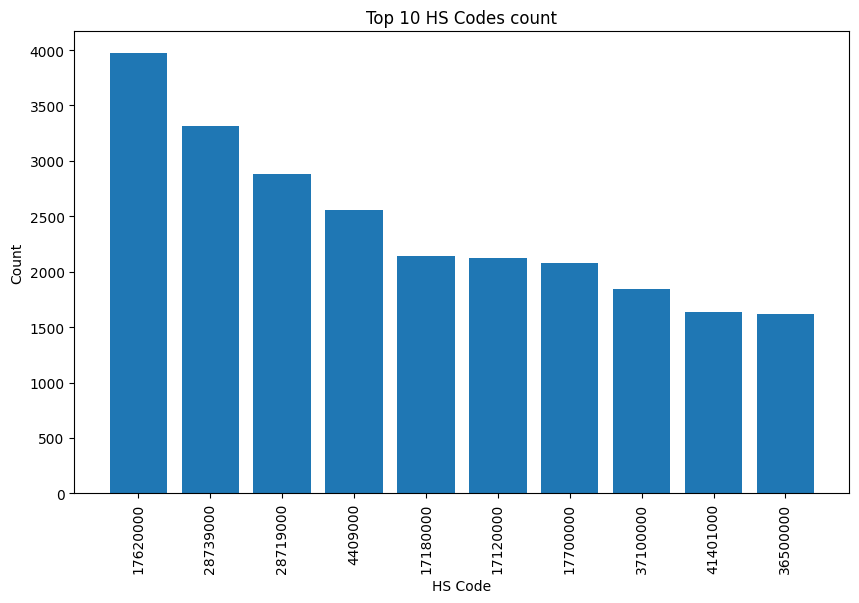

In [7]:
# Totaltop 10 HS CODES
HS_codes= customs_data['HS Code'].value_counts().head(10)
# Plotting
plt.figure(figsize= (10, 6))
plt.bar(HS_codes.index, HS_codes.values)
plt.xlabel('HS Code')
plt.ylabel('Count')
plt.title('Top 10 HS Codes count')
plt.xticks(rotation = 90)
plt.show()


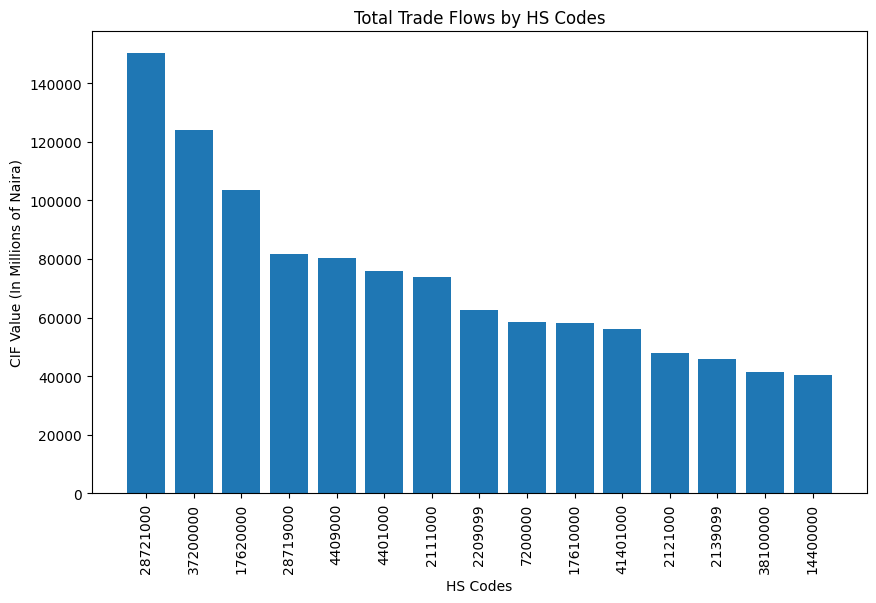

In [8]:
# Total imports by HS Codes
trade_flows= customs_data.groupby('HS Code')['CIF Value (N)'].sum().sort_values(ascending= False).nlargest(15)
trade_flows_mil= (trade_flows/ 1_000_000)

# Plotting
plt.figure(figsize = (10, 6))
plt.bar(trade_flows_mil.index, trade_flows_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('CIF Value (In Millions of Naira)')
plt.title('Total Trade Flows by HS Codes')
plt.xticks(rotation = 90)
plt.show()

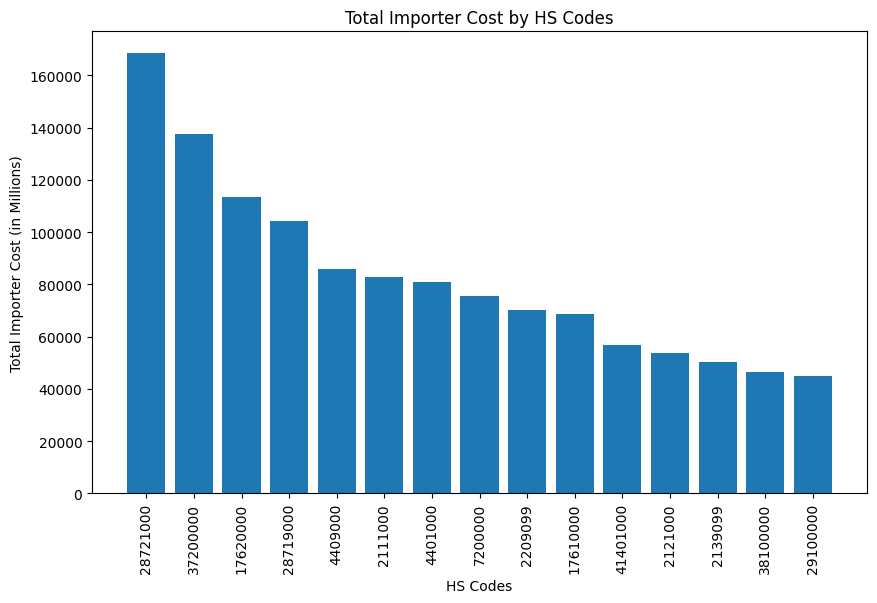

In [9]:
# Total importer's cost by HS Codes
customs_data['importer_cost']= customs_data['CIF Value (N)'] + customs_data['Total Tax(N)']
total_importer_cost= customs_data.groupby('HS Code')['importer_cost'].sum().sort_values(ascending= False).nlargest(15)
# Total importer cost in millions
total_importer_cost_mil= (total_importer_cost/1_000_000)
# Plotting
plt.figure(figsize =(10, 6))
plt.bar(total_importer_cost_mil.index, total_importer_cost_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('Total Importer Cost (in Millions)')
plt.title('Total Importer Cost by HS Codes')
plt.xticks(rotation = 90)
plt.show()


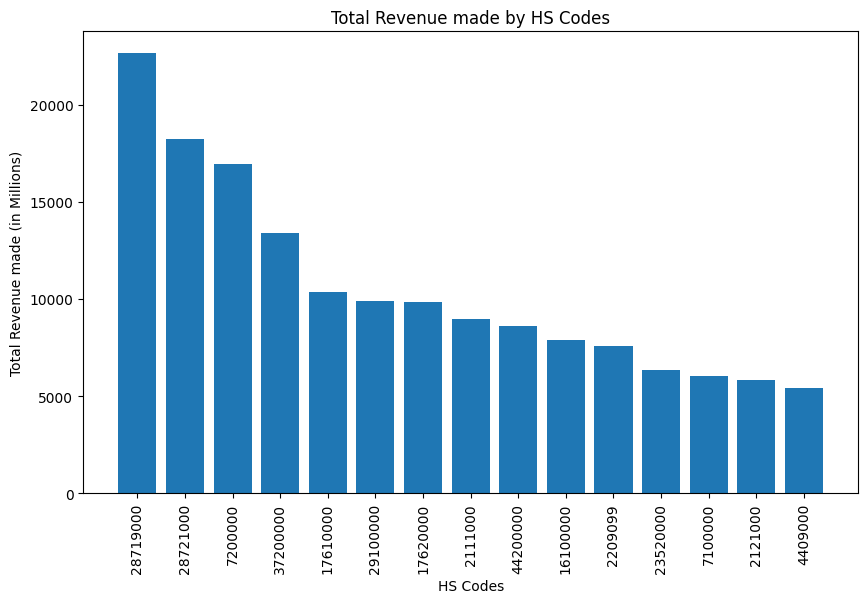

In [10]:
# Total Revenue made by Nigeria
total_revenue= customs_data.groupby('HS Code')['Total Tax(N)'].sum().sort_values(ascending = False).nlargest(15)
# Total revenue in millions
total_revenue_mil = (total_revenue/ 1_000_000)

# Plotting
plt.figure(figsize = (10, 6))
plt.bar(total_revenue_mil.index, total_revenue_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('Total Revenue made (in Millions)')
plt.title('Total Revenue made by HS Codes')
plt.xticks(rotation = 90)
plt.show()



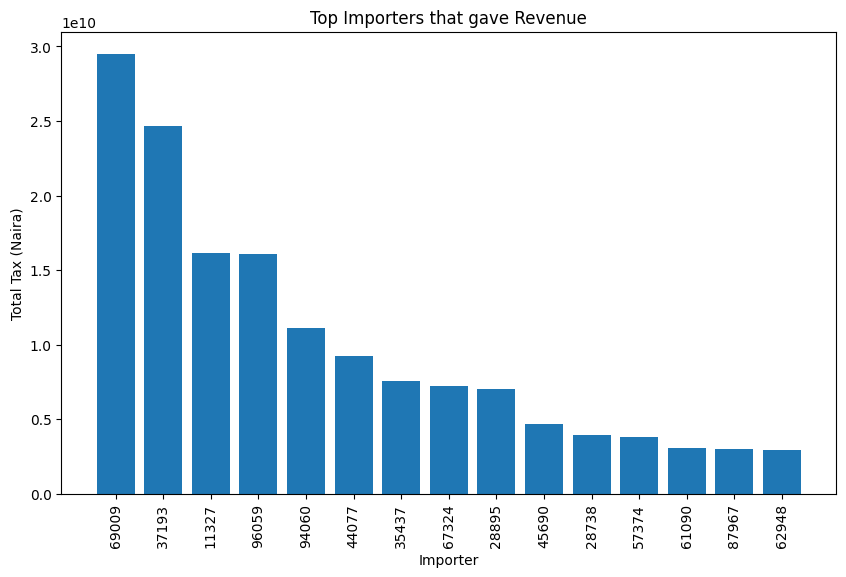

In [11]:
# Key players in trade
importers= customs_data.groupby('Importer')['Total Tax(N)'].sum().sort_values(ascending= False).nlargest(15)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(importers.index, importers.values)
plt.xlabel('Importer')
plt.ylabel('Total Tax (Naira)')
plt.title('Top Importers that gave Revenue')
plt.xticks(rotation = 90)
plt.show()

## Trend over time

/tmp/ipython-input-1469617153.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_cif = customs_data.groupby('Month')['CIF Value (N)'].sum()
/tmp/ipython-input-1469617153.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_tax = customs_data.groupby('Month')['Total Tax(N)'].sum()
/tmp/ipython-input-1469617153.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_mass = customs_data.groupby('Month

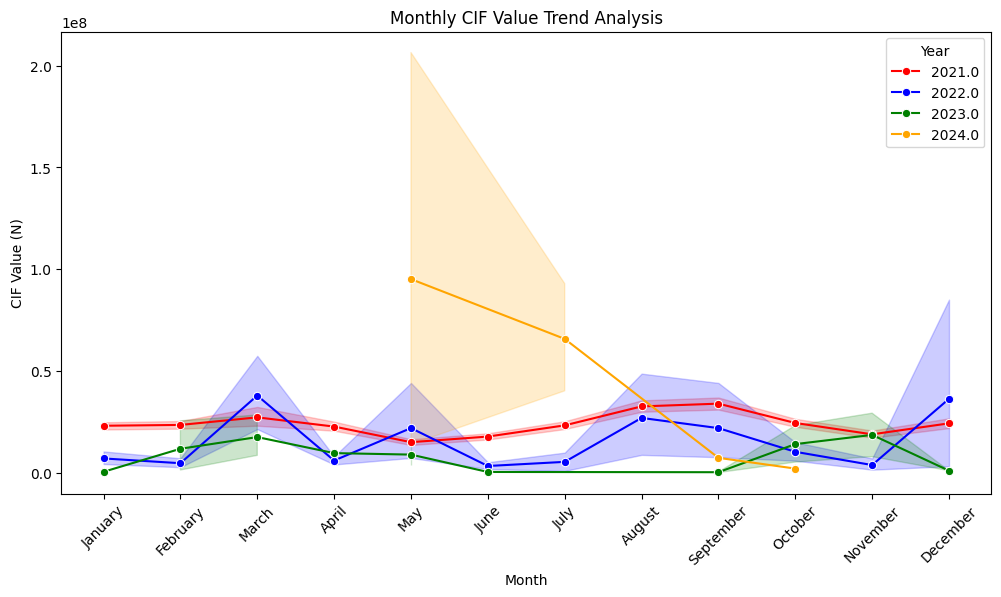

In [13]:
# Grouping datetime by month
customs_data['Date']= pd.to_datetime(customs_data['Receipt Date'])
customs_data['Month']= customs_data['Date'].dt.month

customs_data['Year']= customs_data['Date'].dt.year.astype('Int64')


# Getting Month Names
month_names= {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}
customs_data['Month']= customs_data['Month'].map(month_names)

# Months names being in month order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
customs_data['Month'] = pd.Categorical(customs_data['Month'], categories = months_order, ordered= True)

# Monthly CIF Value
monthly_cif = customs_data.groupby('Month')['CIF Value (N)'].sum()

# Monthly Tax
monthly_tax = customs_data.groupby('Month')['Total Tax(N)'].sum()

# Monthly Mass(KG)
monthly_mass = customs_data.groupby('Month')['Mass(KG)'].sum()

custom_palette = {
    2021: "red",
    2022: "blue",
    2023: "green",
    2024: "orange"
}
# Plotting the graphs in subplot using line graph
# For monthly CIF
plt.figure(figsize = (12, 6))
sns.lineplot(
    data=customs_data,
    x='Month',
    y='CIF Value (N)',
    hue='Year',
    marker='o',
    palette=custom_palette
)
plt.title('Monthly CIF Value Trend Analysis')
plt.xlabel('Month')
plt.ylabel('CIF Value (N)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.show()




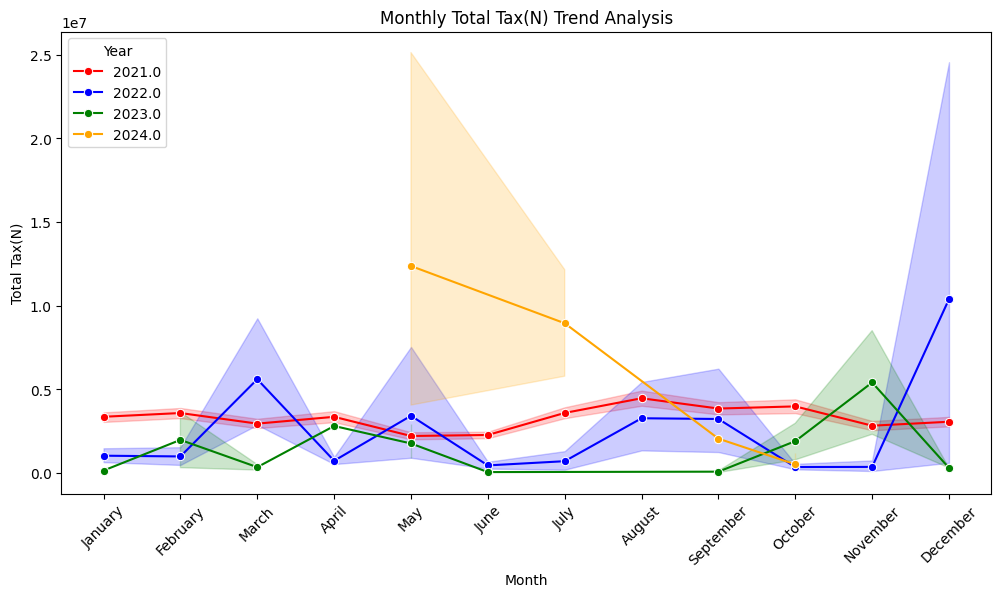

In [14]:
# For Monthly Tax
plt.figure(figsize= (12, 6))
sns.lineplot(
    data=customs_data,
    x='Month',
    y='Total Tax(N)',
    hue='Year',
    marker='o',
    palette=custom_palette
)
plt.title('Monthly Total Tax(N) Trend Analysis')
plt.xlabel('Month')
plt.ylabel('Total Tax(N)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.show()

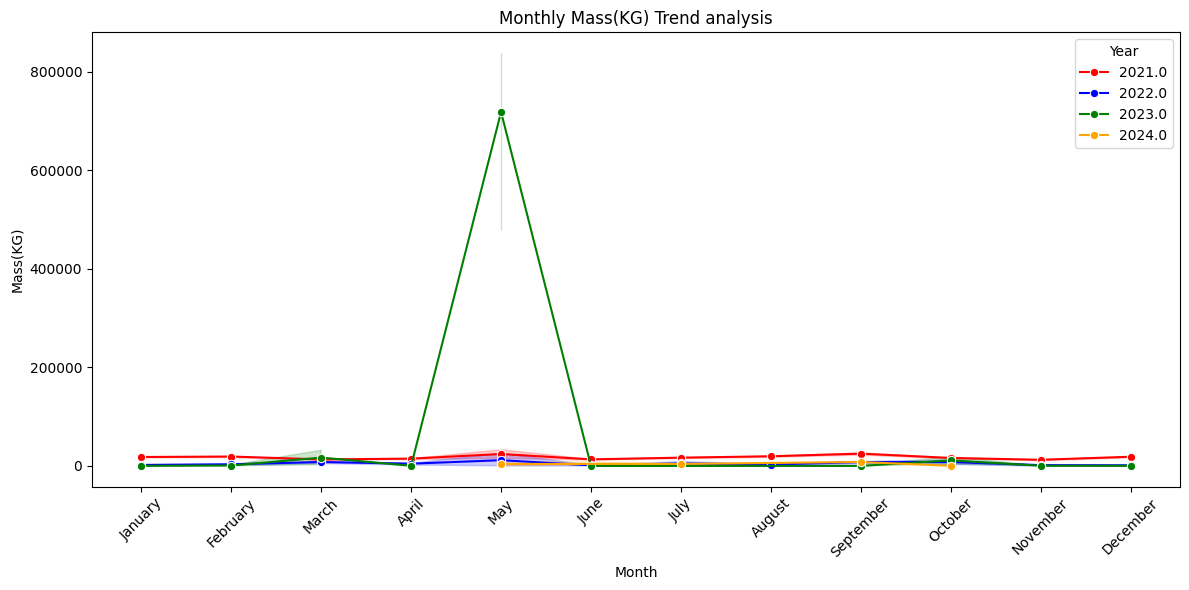

In [15]:
# For Monthtly Mass(KG)
plt.figure(figsize= (12,6))
sns.lineplot(
    data= customs_data,
    x = 'Month',
    y = 'Mass(KG)',
    hue= 'Year',
    marker = 'o',
    palette = custom_palette

)
plt.title('Monthly Mass(KG) Trend analysis')
plt.xlabel('Month')
plt.ylabel('Mass(KG)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.tight_layout()
plt.show()


## Outlier Detection

### ***Purpose***

The risk score is a simple way to combine different anomaly signals into one metric.
It helps customs analysts quickly identify and prioritize unusual or high-risk shipments for investigation.

#### ***Dimensions Used***

We measure anomalies across three key features (dimensions) of trade data:

- ***Value per KG (value_per_kg):***

***Formula:*** CIF Value (₦) ÷ Mass (KG)

Detects shipments that are unusually expensive per unit weight (e.g., jewelry, chips) or suspiciously cheap (e.g., bulk commodities).

- ***Tax-to-CIF Ratio (tax_to_cif):***

***Formula***: Total Tax (₦) ÷ CIF Value (₦)

Detects shipments where taxes are suspiciously low (possible under-declaration) or unusually high (possible misclassification).

- ***CIF Value (CIF Value (₦)):***

The total customs value of the shipment.

Detects extremely high-value shipments (luxury goods, bulk trade) or abnormally low values (possible fraud or errors).

In [44]:
# Clean: avoid division by zero
customs_data = customs_data[customs_data["Mass(KG)"] > 0]
customs_data = customs_data[customs_data["CIF Value (N)"] > 0]

# Derived features
customs_data["value_per_kg"] = customs_data["CIF Value (N)"] / customs_data["Mass(KG)"]
customs_data["tax_to_cif"] = customs_data["Total Tax(N)"] / customs_data["CIF Value (N)"]


In [45]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)


In [46]:
def detect_zscore_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return abs((series - mean) / std) > threshold


#### Risk Score Summary

The Risk Score is a simple way to flag unusual trade transactions by combining different anomaly checks. Each check looks for unusual patterns in the data.

0 → Normal (no anomalies detected)

1 → Suspicious in one aspect (minor concern)

2 → Suspicious in two aspects (moderate concern)

3 → Suspicious in all three aspects (high risk)

***Dimensions Used***

- ***Value per KG:*** unusually high or low cost per unit mass.

- ***Tax-to-CIF Ratio:*** abnormal tax compared to the declared CIF value.

- ***CIF Value:*** overall trade value is extremely high or low compared to typical patterns.

By combining these, the Risk Score provides a quick indicator of whether a record looks normal or potentially fraudulent.

In [47]:
# Outliers for Value per KG
customs_data["outlier_value_per_kg"] = detect_iqr_outliers(customs_data["value_per_kg"])

# Outliers for Tax/CIF
customs_data["outlier_tax_to_cif"] = detect_iqr_outliers(customs_data["tax_to_cif"])

# Outliers for CIF itself (extreme shipments)
customs_data["outlier_cif"] = detect_zscore_outliers(customs_data["CIF Value (N)"])


In [48]:
customs_data["risk_score"] = (
    customs_data["outlier_value_per_kg"].astype(int) +
    customs_data["outlier_tax_to_cif"].astype(int) +
    customs_data["outlier_cif"].astype(int)
)


In [50]:
# Top 20 risky shipments
suspicious = customs_data.sort_values("risk_score", ascending=False).head(20)

print("Top Suspicious Shipments", suspicious)


Top Suspicious Shipments       Custom Office Reg Number Importer   HS Code  FOB Value (N)  \
29561      HM CARGO     C58195    69009  23520000      456165300   
2215        AA PORT     C18220    80918  17620000      515341386   
2214        AA PORT     C18220    80918  17620000      515341386   
39516      HM CARGO     C91460    69009  17620000     1319231050   
7019        AA PORT     C44933    94060  17620000      422929708   
15386      HM CARGO    C102951    69009  17120000      345945715   
7020        AA PORT     C44933    94060  17620000      422929708   
7021        AA PORT     C44933    94060  17620000      422929708   
7022        AA PORT     C44933    94060  17620000      422929708   
2211        AA PORT     C18212    80918  17620000     1258671242   
2210        AA PORT     C18212    80918  17620000     1258671242   
47216          RP_3      C8186    90269   2139099     1324630191   
47041          RP_3      C7166    90269  31100000     3522309395   
2231        AA PORT    

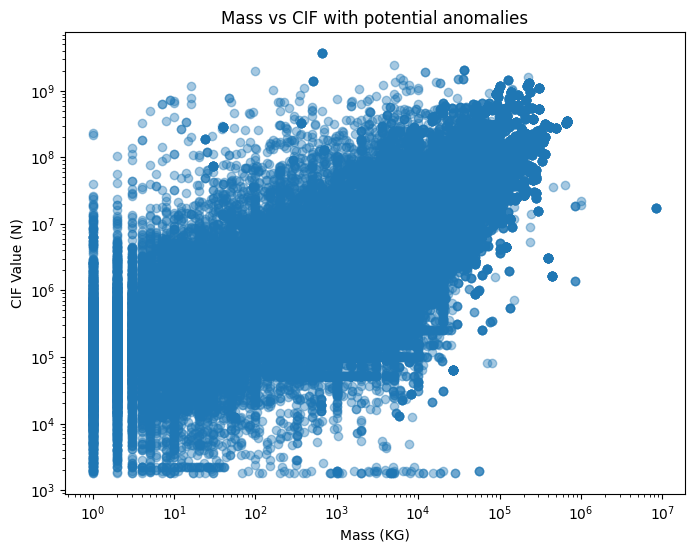

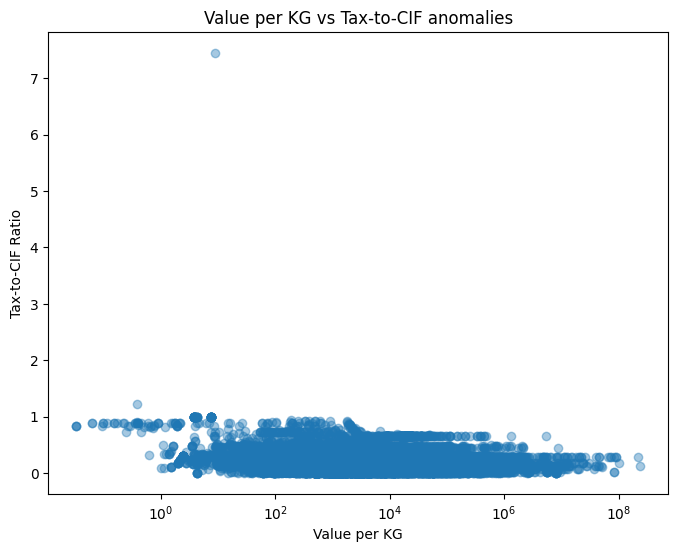

In [51]:
import matplotlib.pyplot as plt

# Scatter: Mass vs CIF
plt.figure(figsize=(8,6))
plt.scatter(customs_data["Mass(KG)"], customs_data["CIF Value (N)"], alpha=0.4)
plt.xlabel("Mass (KG)")
plt.ylabel("CIF Value (N)")
plt.title("Mass vs CIF with potential anomalies")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Scatter: Value per KG vs Tax-to-CIF
plt.figure(figsize=(8,6))
plt.scatter(customs_data["value_per_kg"], customs_data["tax_to_cif"], alpha=0.4)
plt.xlabel("Value per KG")
plt.ylabel("Tax-to-CIF Ratio")
plt.title("Value per KG vs Tax-to-CIF anomalies")
plt.xscale("log")
plt.show()


In [ ]:
customs_data.info()

## Logistics and Shipment KPIs

- Total Number of Shipments
- Average Number of Containers per Importer
-  Most Common Container Size
- Total Weight of Imports by Country of Origin

In [24]:
# Total number of shipments
total_shipments= len(customs_data)
print(f'Total Number of Shipments: {total_shipments}')

Total Number of Shipments: 77789


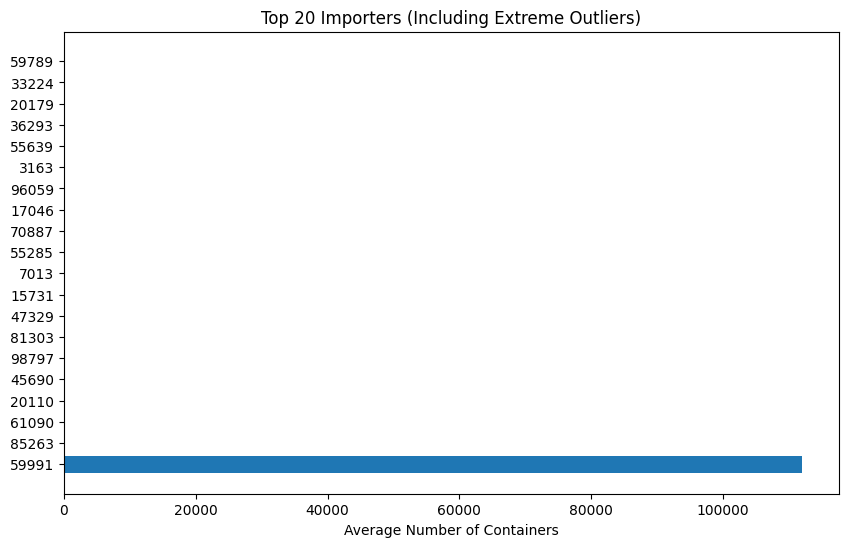

In [25]:
# Average number of containers including outlier

avg_container= customs_data.groupby('Importer')['Nbr Of Containers'].mean().nlargest(20)

# Plotting graph
plt.figure(figsize=(10,6))
plt.barh(avg_container.index, avg_container.values)
plt.xlabel('Average Number of Containers')
plt.title('Top 20 Importers (Including Extreme Outliers)')
plt.show()

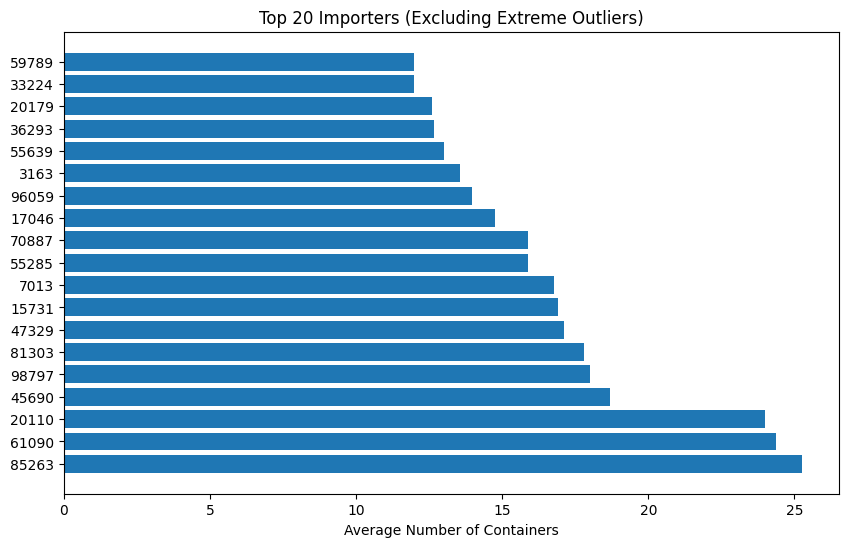

In [26]:
# Average number of containers per importer
avg_container= customs_data.groupby('Importer')['Nbr Of Containers'].mean().nlargest(20)
top_importers = avg_container.nlargest(20)

filtered = avg_container[avg_container < avg_container.quantile(0.95)]  # drop top 5% extreme
top_importers = filtered.nlargest(20)

# Plotting graph
plt.figure(figsize=(10,6))
plt.barh(top_importers.index, top_importers.values)
plt.xlabel('Average Number of Containers')
plt.title('Top 20 Importers (Excluding Extreme Outliers)')
plt.show()



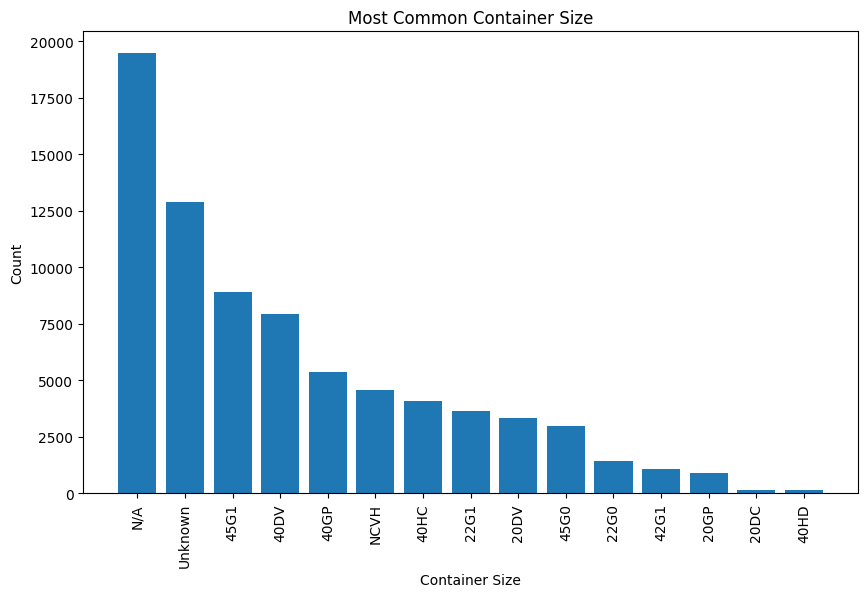

In [27]:
# Most Common Container Size
container_size= customs_data['Container Size'].value_counts().head(15)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(container_size.index, container_size.values)
plt.xlabel('Container Size')
plt.ylabel('Count')
plt.title('Most Common Container Size')
plt.xticks(rotation= 90)
plt.show()

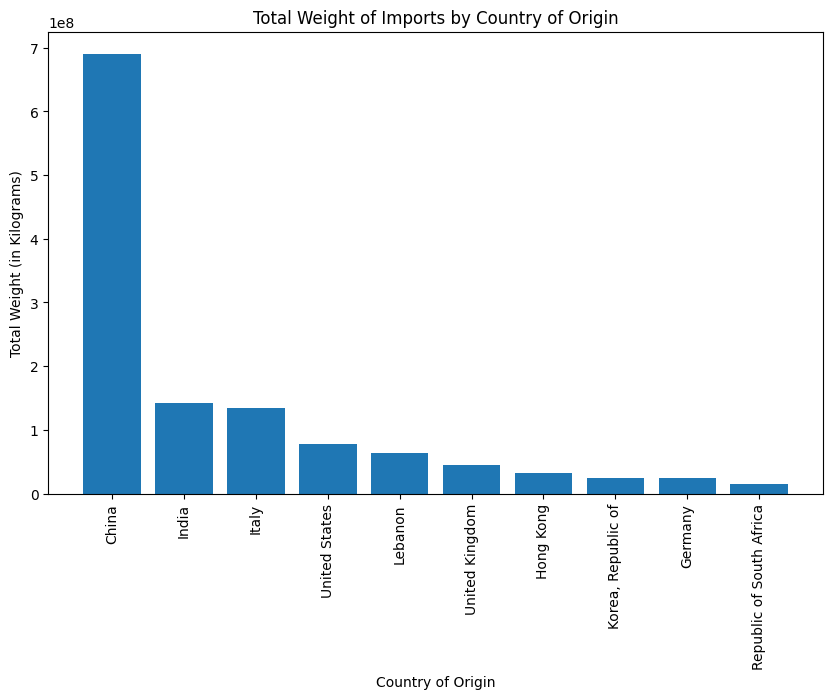

In [28]:
# Total Weight of Imports by Country of Origin
total_weight= customs_data.groupby('Country of Origin')['Mass(KG)'].sum().sort_values().nlargest(10)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(total_weight.index, total_weight.values)
plt.xlabel('Country of Origin')
plt.ylabel('Total Weight (in Kilograms)')
plt.title('Total Weight of Imports by Country of Origin')
plt.xticks(rotation = 90)
plt.show()

In [29]:
customs_data['Container Size'].unique()

array(['N/A', '45G0', '45G1', '40DV', '42G1', '20GP', '40GP', '40HC',
       '20DV', '22G1', '22G0', '45U1', '20DC', '45P3', 'Unknown', '45GP',
       '22U1', '40OT', '42U0', '42U1', '42G0', '42P0', '40DC', 'L5G1',
       '22P3', '42P3', '20OT', '22P1', '25G1', '2040', '40FL', '40BK',
       '10DV', '20VH', '40PL', '20PL', '40VH', '20SN', '20FL', 'NCVH',
       '42P1', '49P0', '0', '40UT', 'HNCV', '40HD', '20UT', '40PS',
       '20HD', '60MF', '45R1', '44G1', '2200', '4300', '40', '22R1',
       '20VE', '20HC', '42U5'], dtype=object)

In [31]:
payload_thresholds = {
    'N/A': None,
    '45G0': 29750,
    '45G1': 29750,
    '40DV': 28200,
    '42G1': 30480,
    '20GP': 28200,
    '40GP': 28200,
    '40HC': 28200,
    '20DV': 28200,
    '22G1': 21400,
    '22G0': 21400,
    '45U1': 29750,
    '20DC': 28200,
    '45P3': 29750,
    'Unknown': None,
    '45GP': 29750,
    '22U1': 21400,
    '40OT': 28200,
    '42U0': 30480,
    '42U1': 30480,
    '42G0': 30480,
    '42P0': 30480,
    '40DC': 28200,
    'L5G1': None,   # special code, unclear
    '22P3': 21400,
    '42P3': 30480,
    '20OT': 28200,
    '22P1': 21400,
    '25G1': 25000,
    '2040': None,   # unclear
    '40FL': 28200,
    '40BK': 28200,
    '10DV': None,   # very rare small container
    '20VH': 28200,
    '40PL': 28200,
    '20PL': 28200,
    '40VH': 28200,
    '20SN': 28200,
    '20FL': 28200,
    'NCVH': None,   # unclear special type
    '42P1': 30480,
    '49P0': None,   # unclear
    '0': None,
    '40UT': 28200,
    'HNCV': None,   # unclear
    '40HD': 28200,
    '20UT': 28200,
    '40PS': 28200,
    '20HD': 28200,
    '60MF': 60000,  # large special container
    '45R1': 29750,
    '44G1': 30480,
    '2200': None,
    '4300': None,
    '40': 28200,    # assume generic 40ft
    '22R1': 21400,
    '20VE': 28200,
    '20HC': 28200,
    '42U5': 30480
}


In [32]:
#Map payload to dataset
customs_data['Max_Payload'] = customs_data['Container Size'].map(payload_thresholds)

# Group by importer & container type
avg_mass = (
    customs_data.groupby(['Importer', 'Container Size'])['Mass(KG)']
    .mean()
    .reset_index()
)

# Add payload threshold to comparison
avg_mass['Max_Payload'] = avg_mass['Container Size'].map(payload_thresholds)

# Flag if importer’s avg mass exceeds payload
avg_mass['Exceeds_Payload'] = avg_mass['Mass(KG)'] > avg_mass['Max_Payload']

#  avg_mass now contains the results per importer + container type#


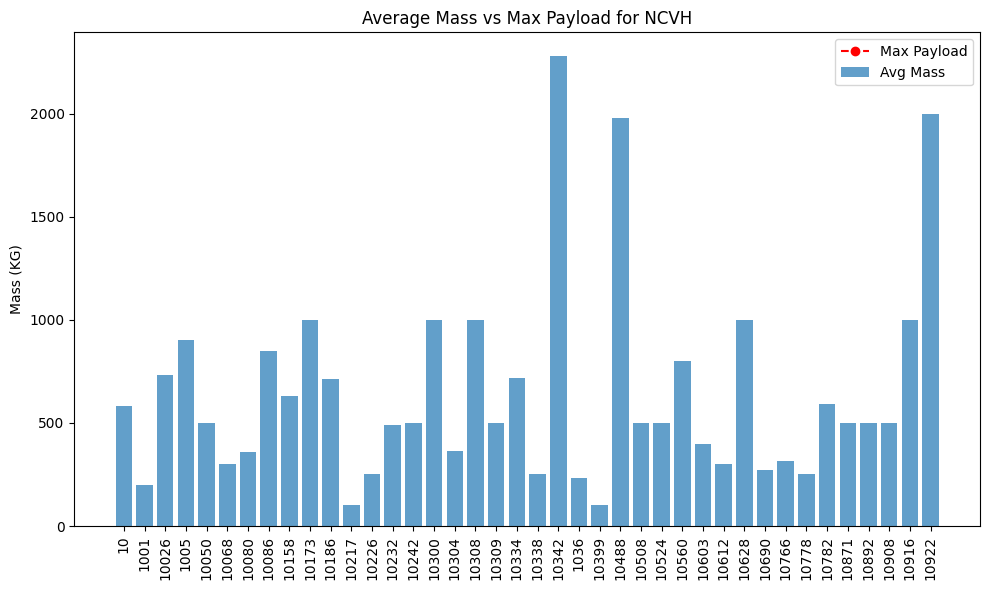

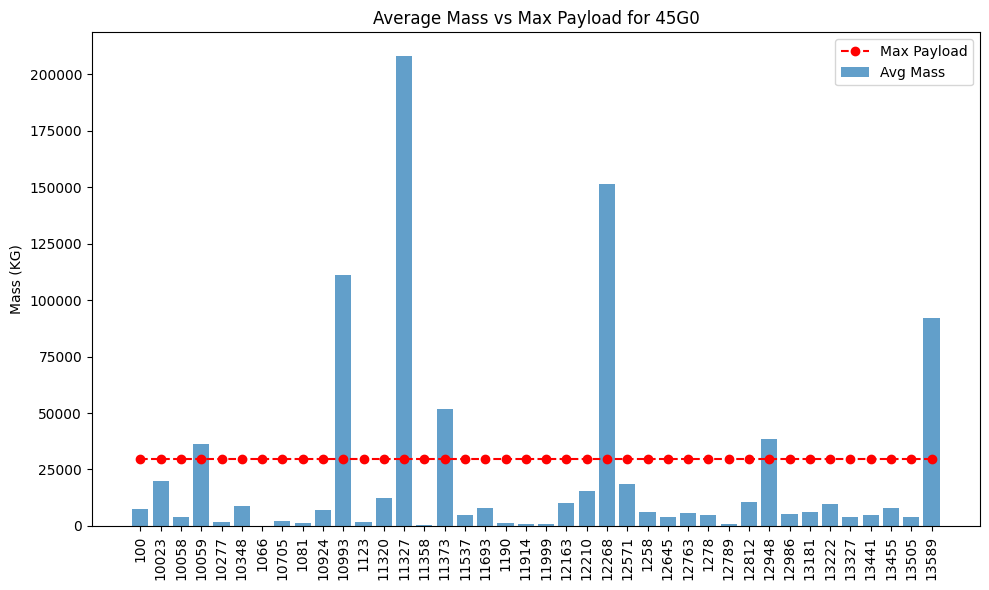

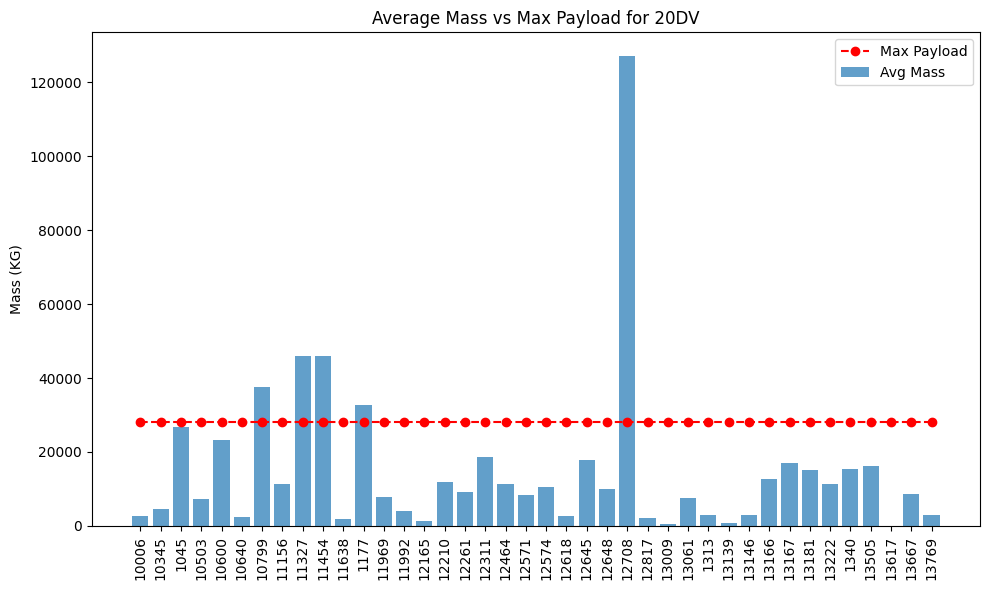

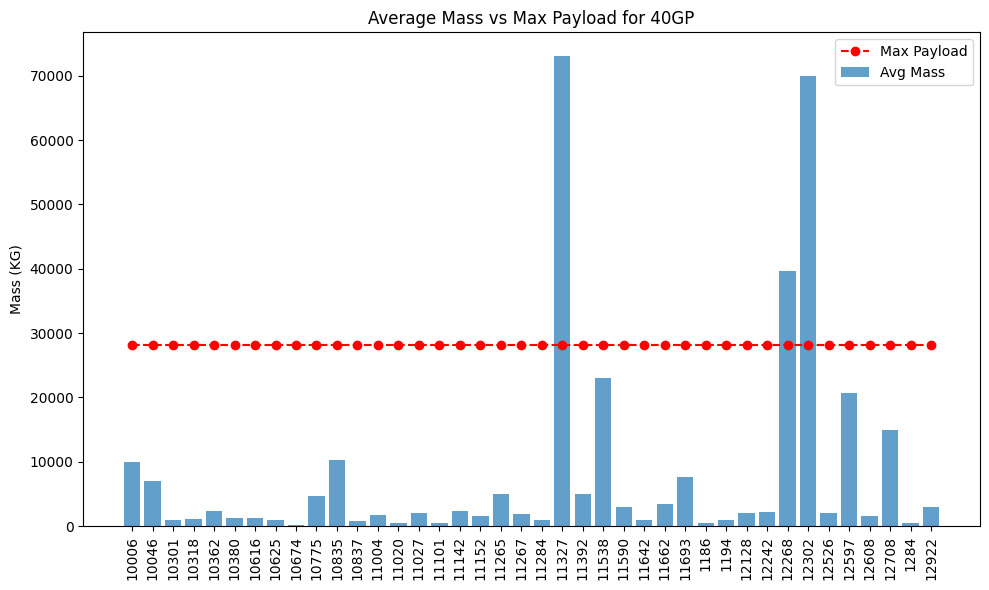

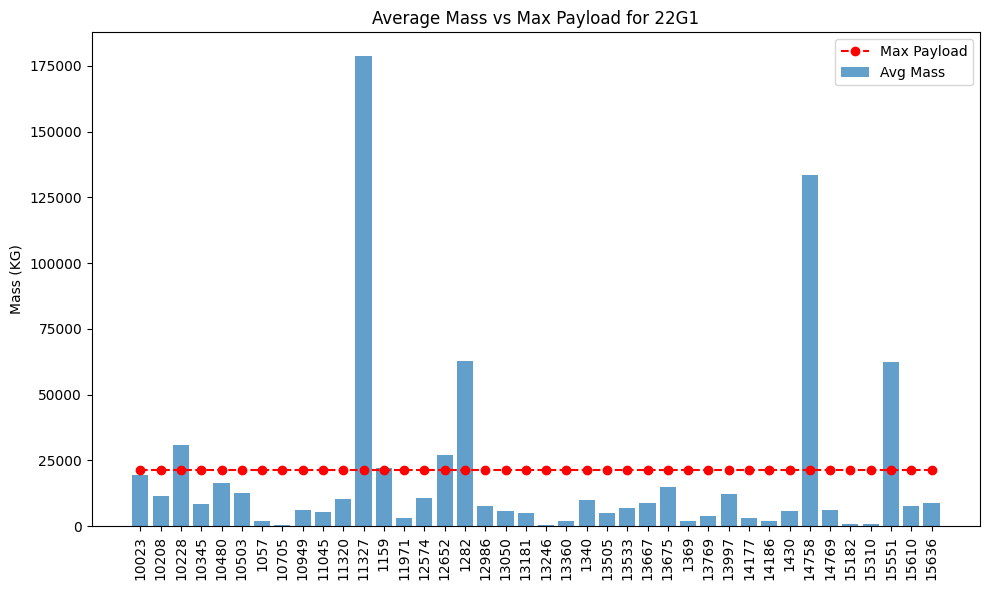

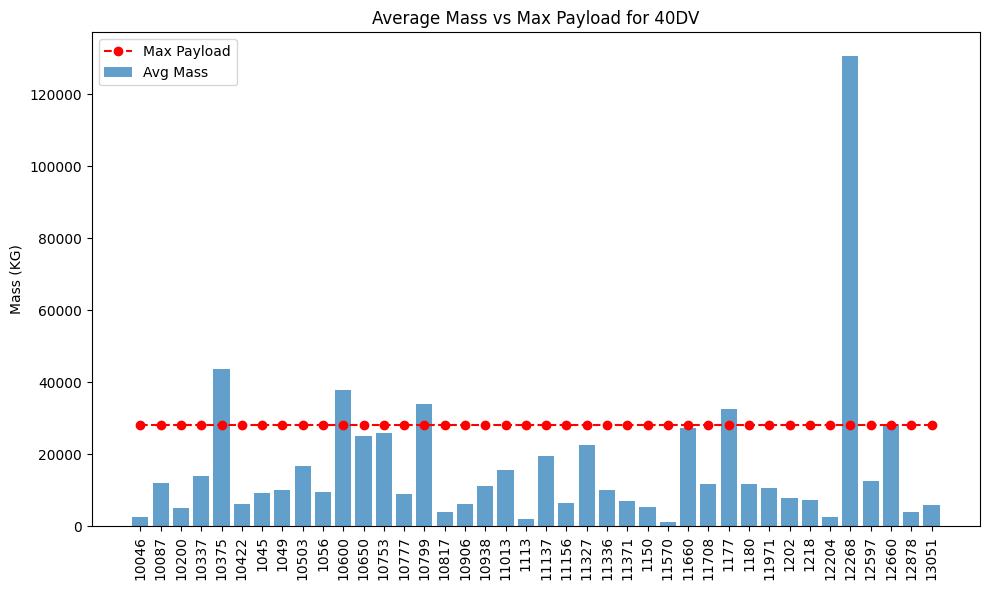

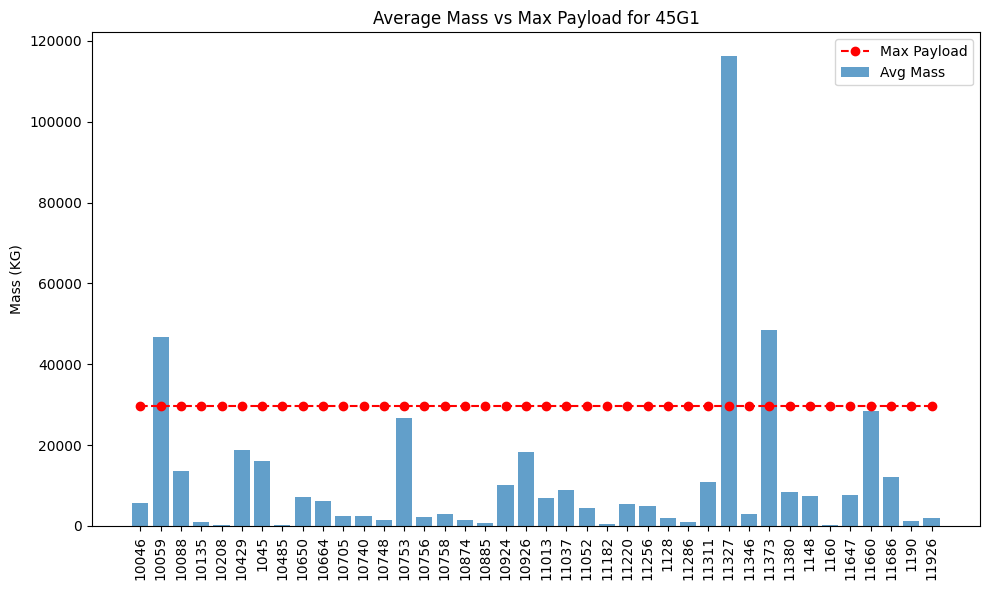

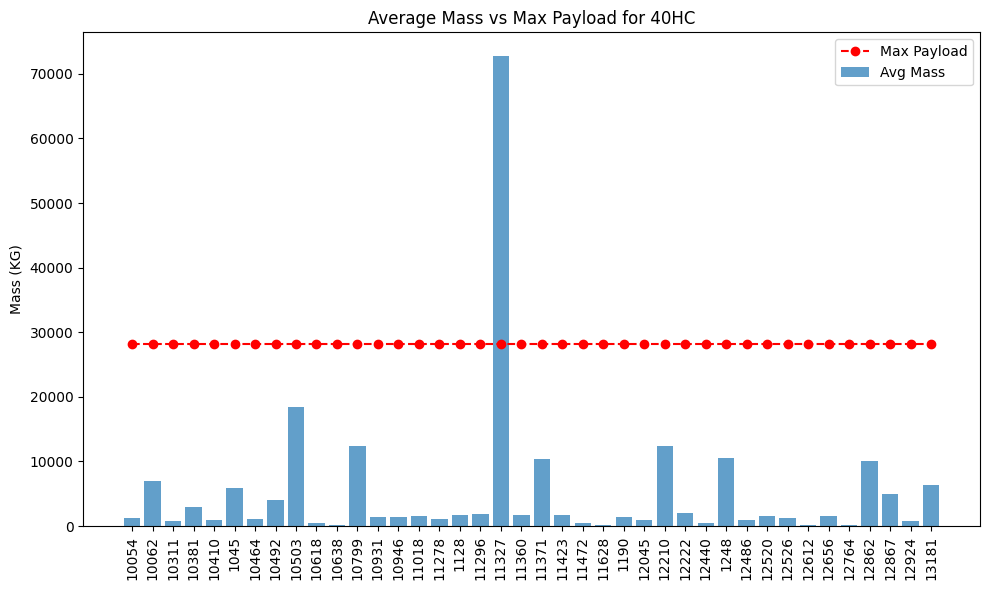

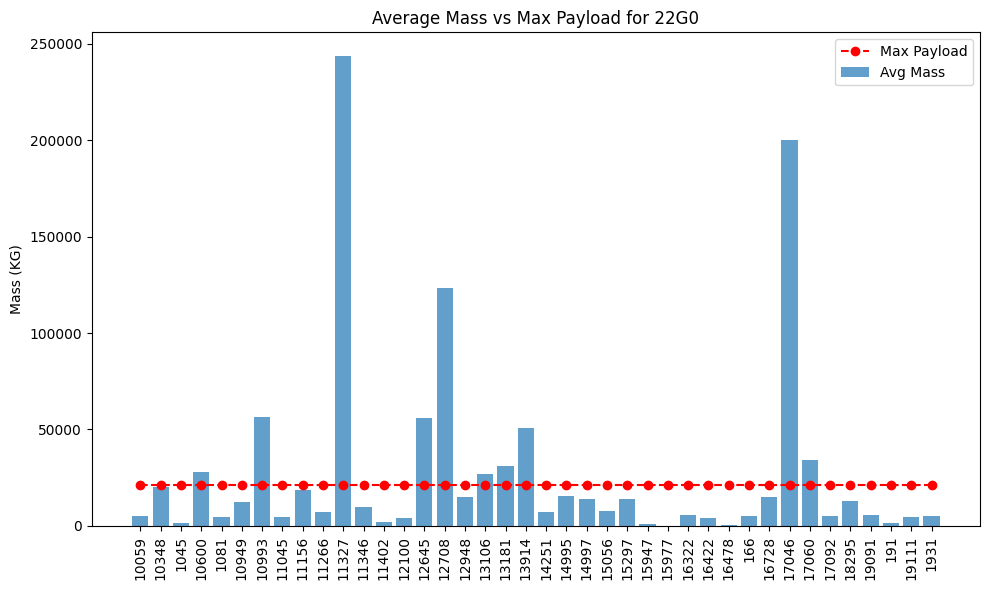

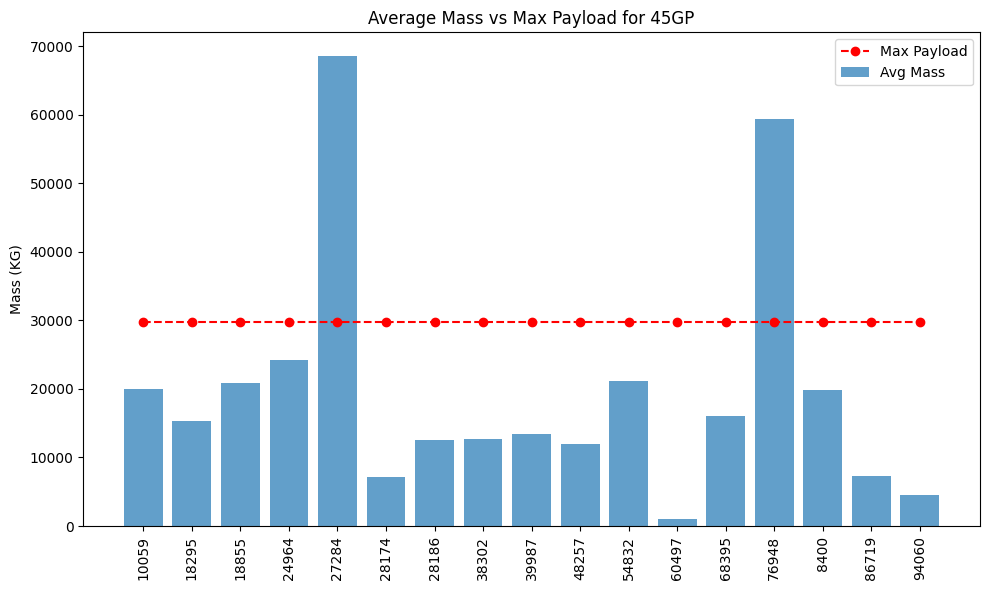

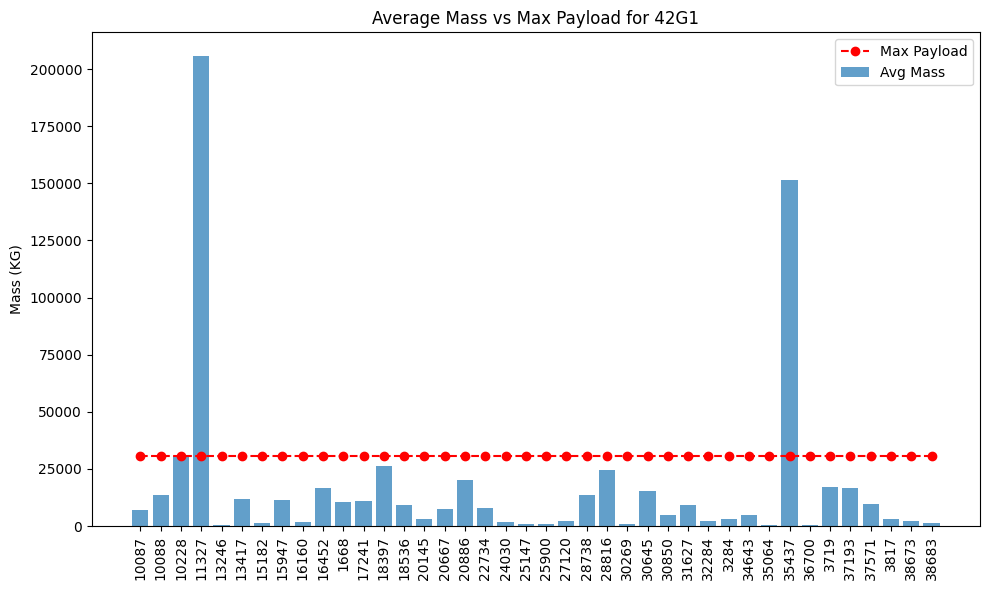

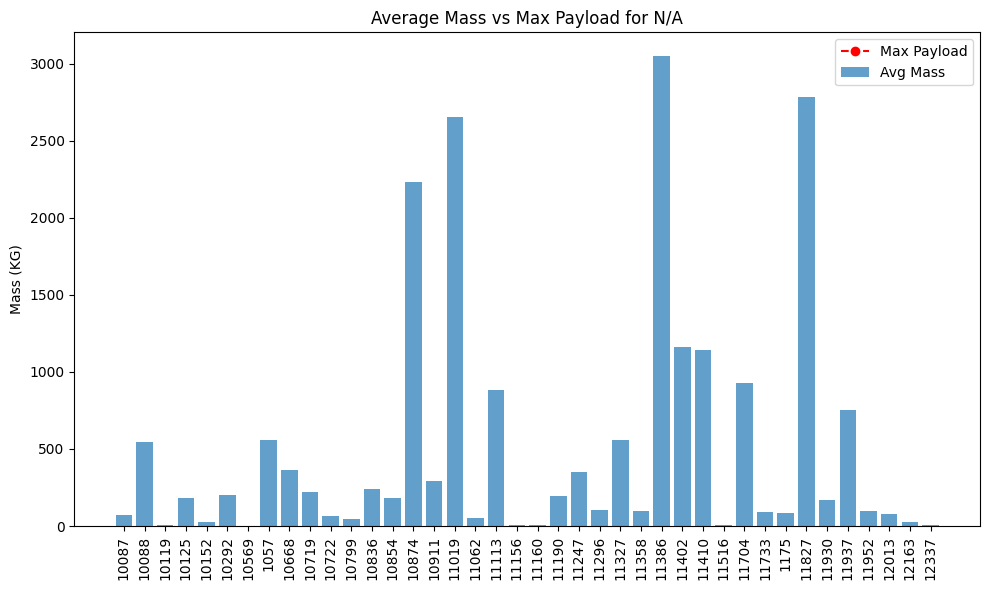

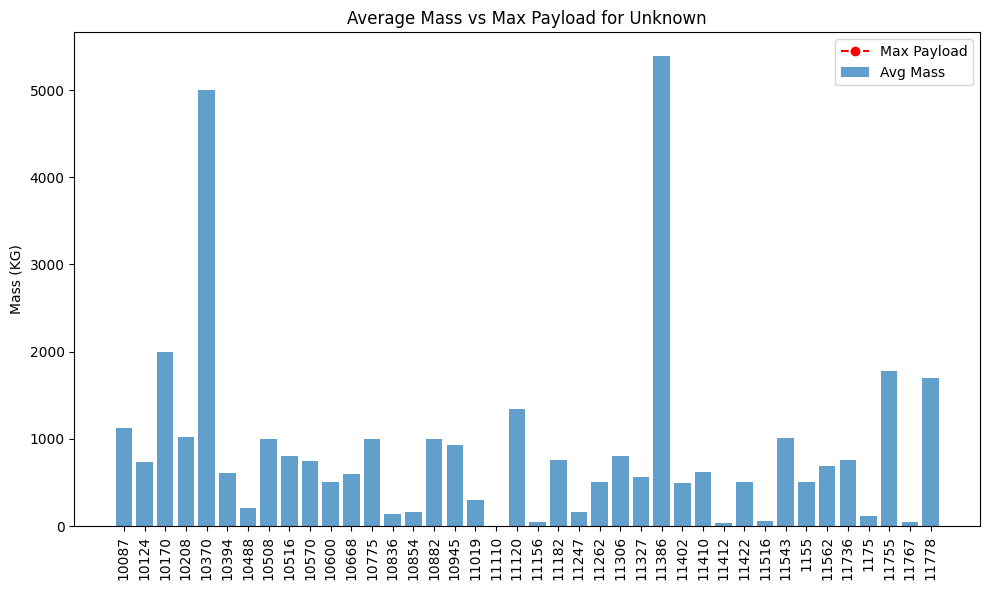

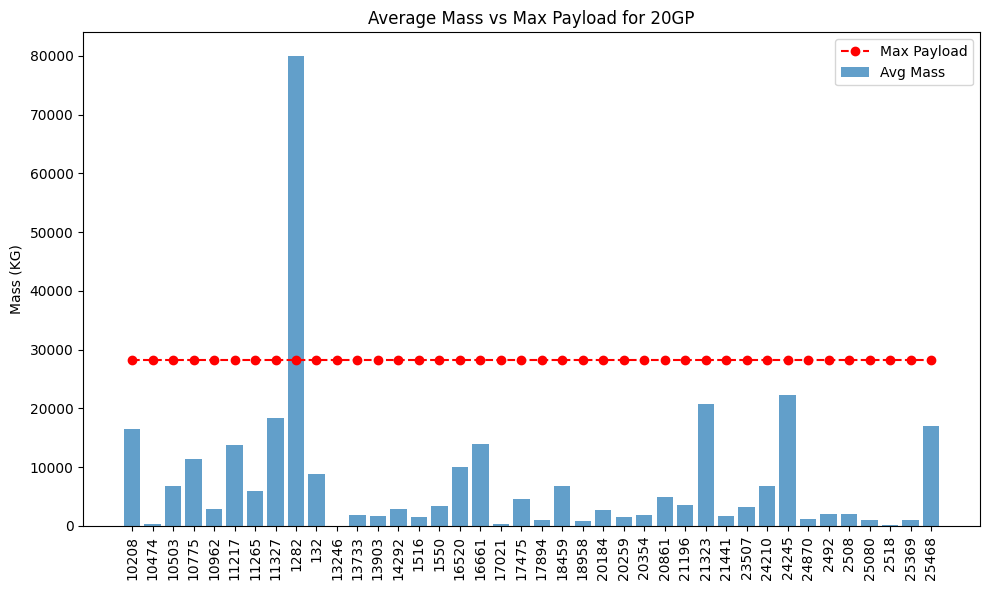

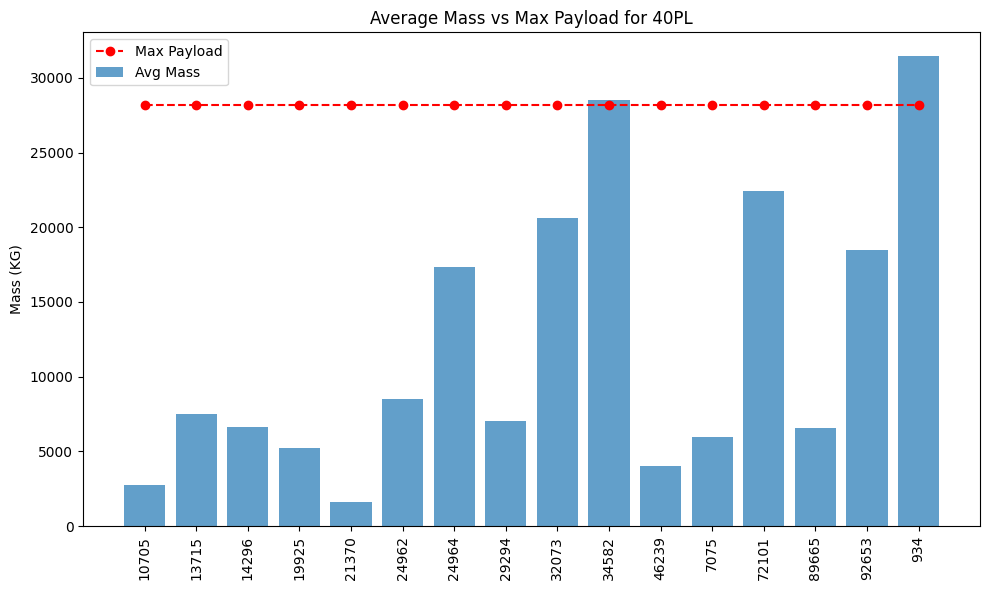

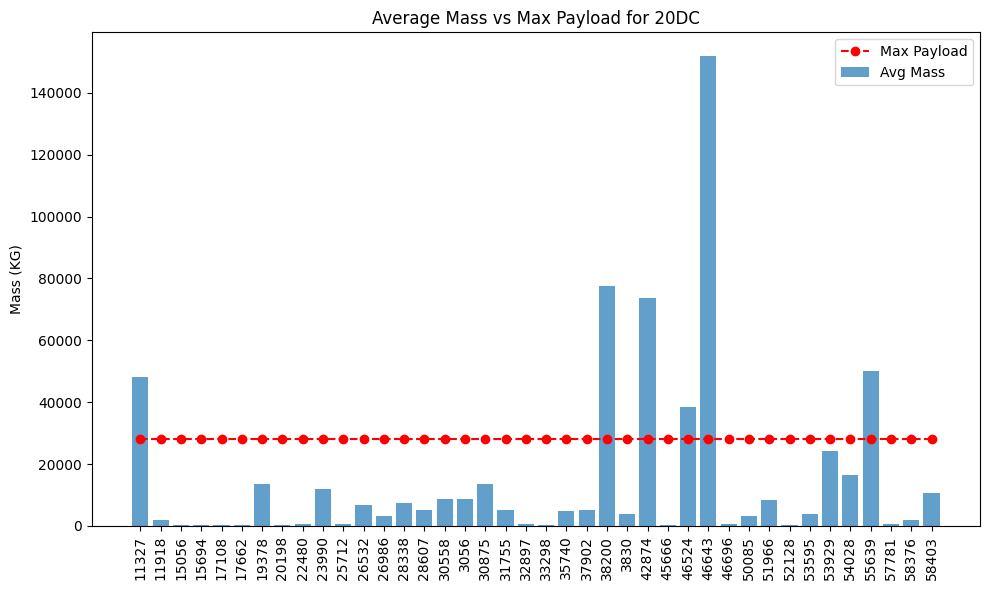

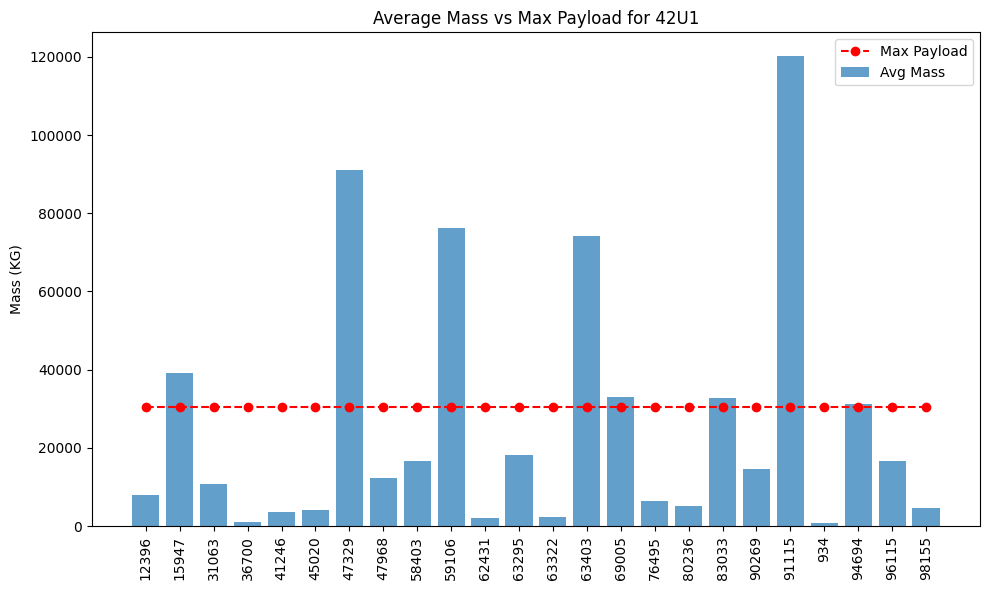

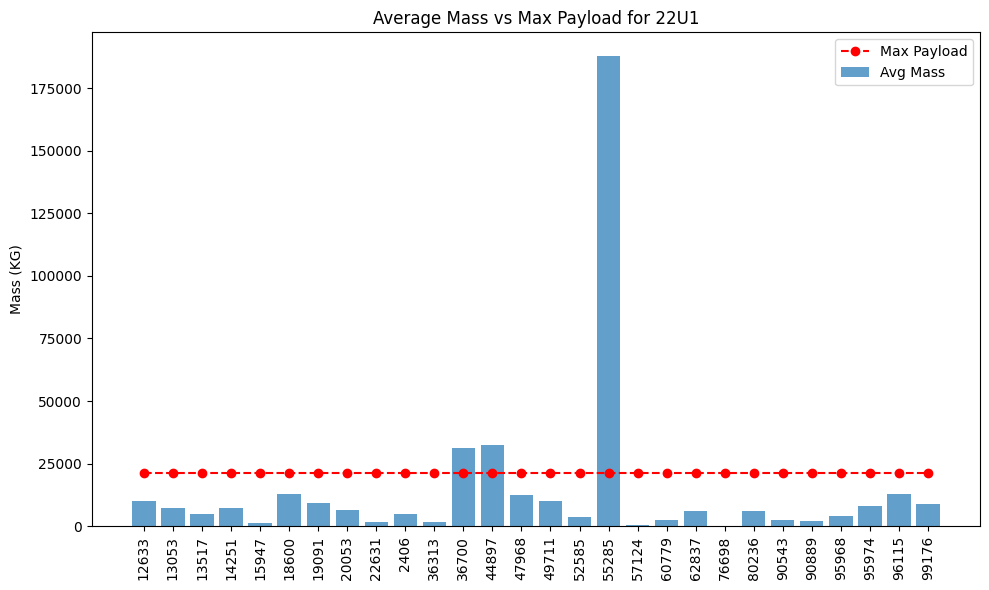

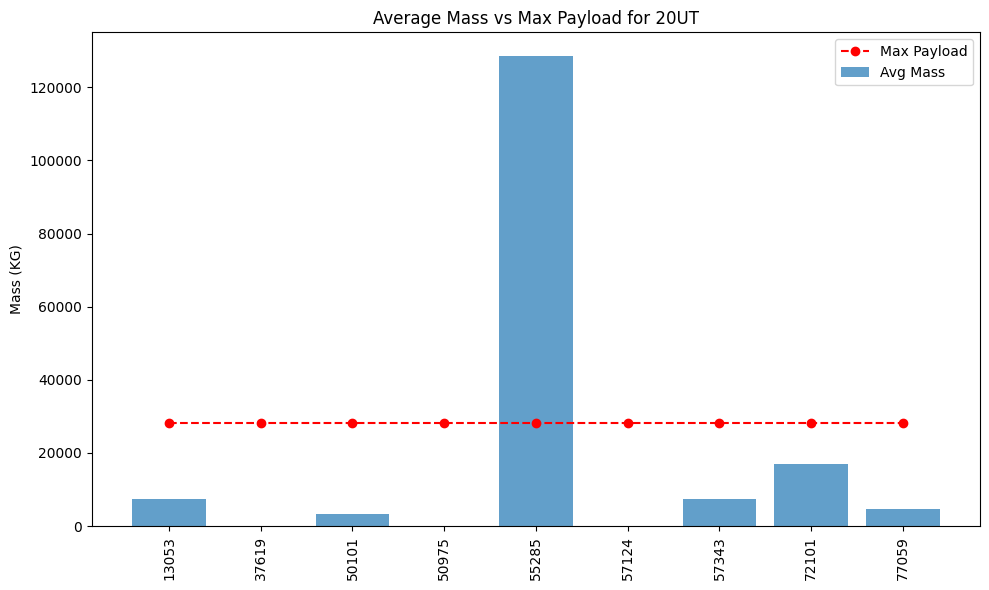

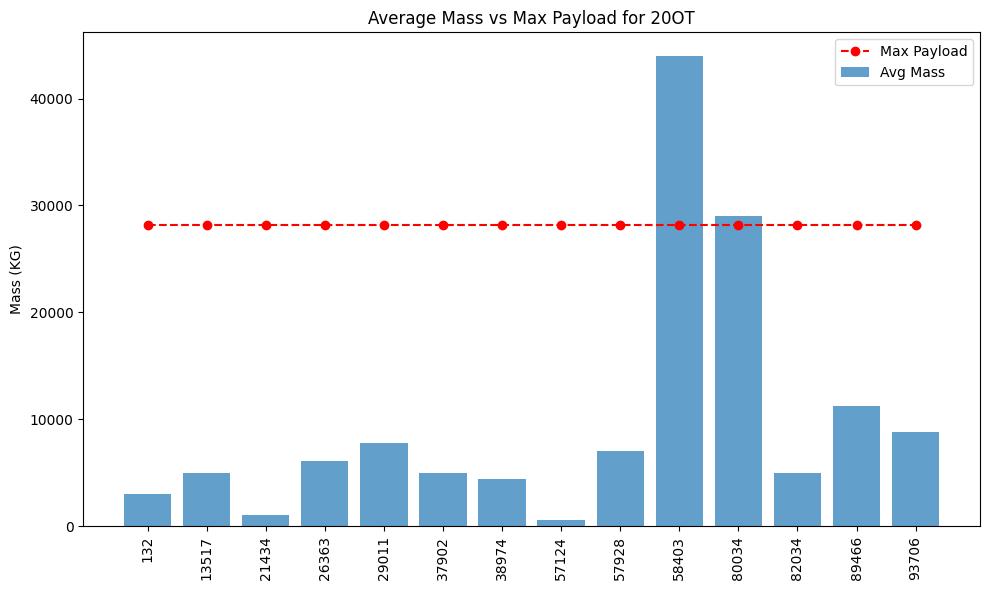

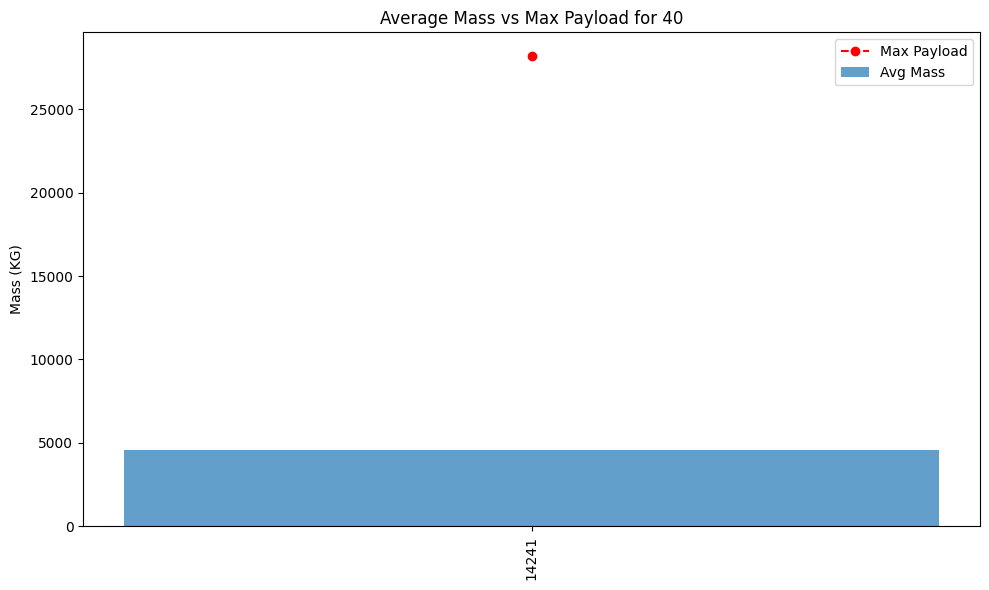

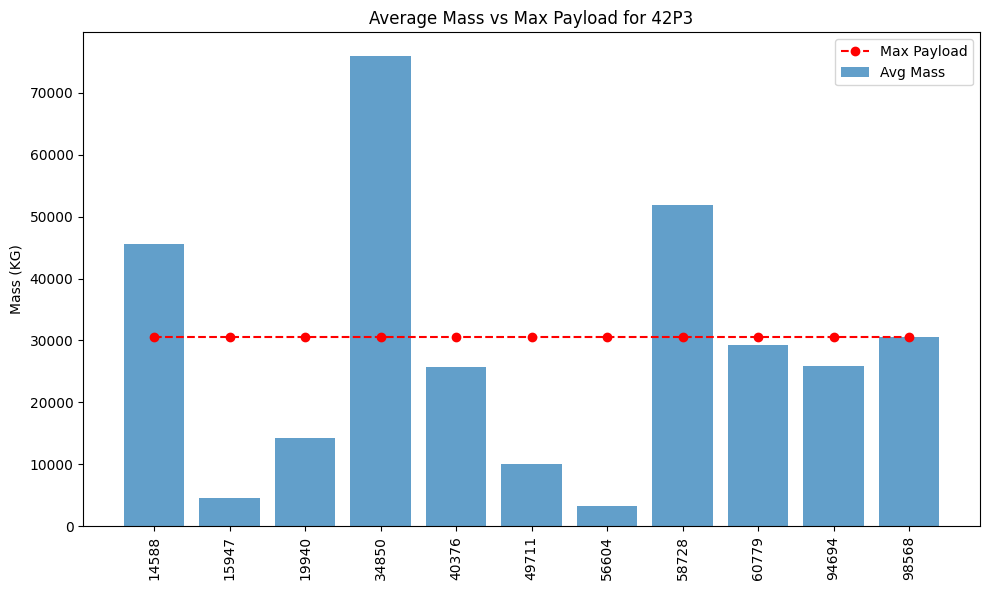

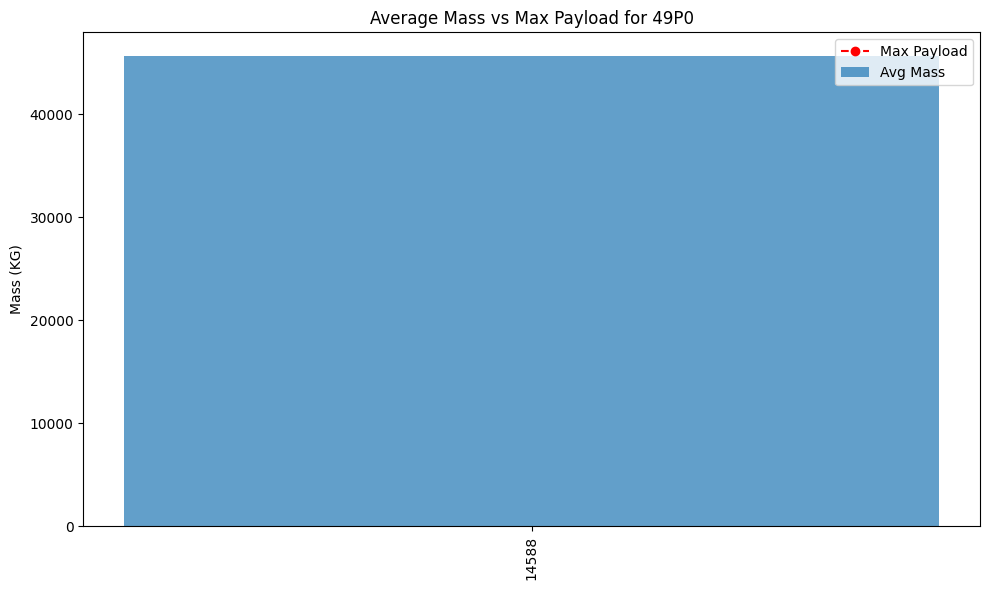

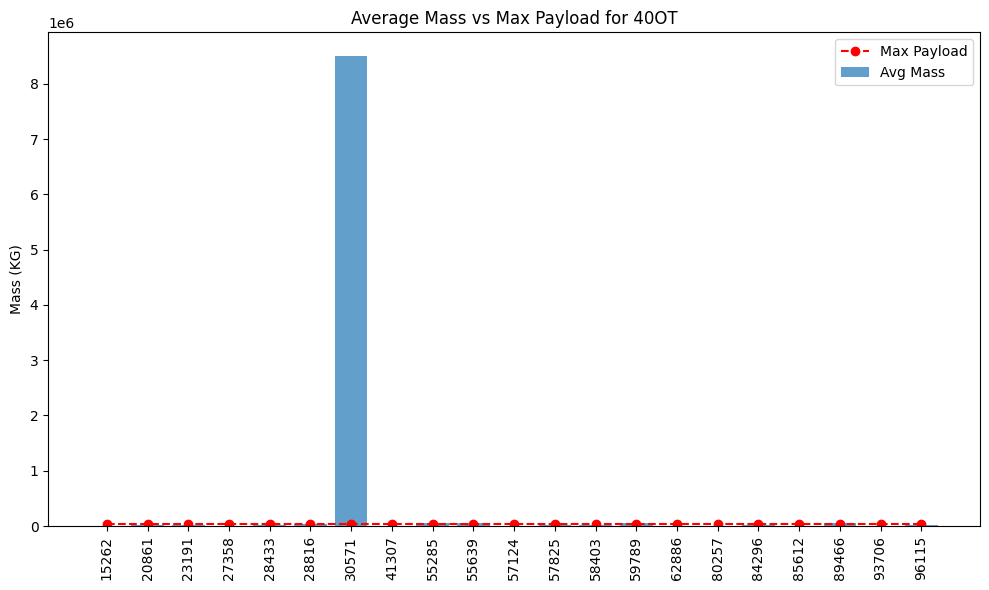

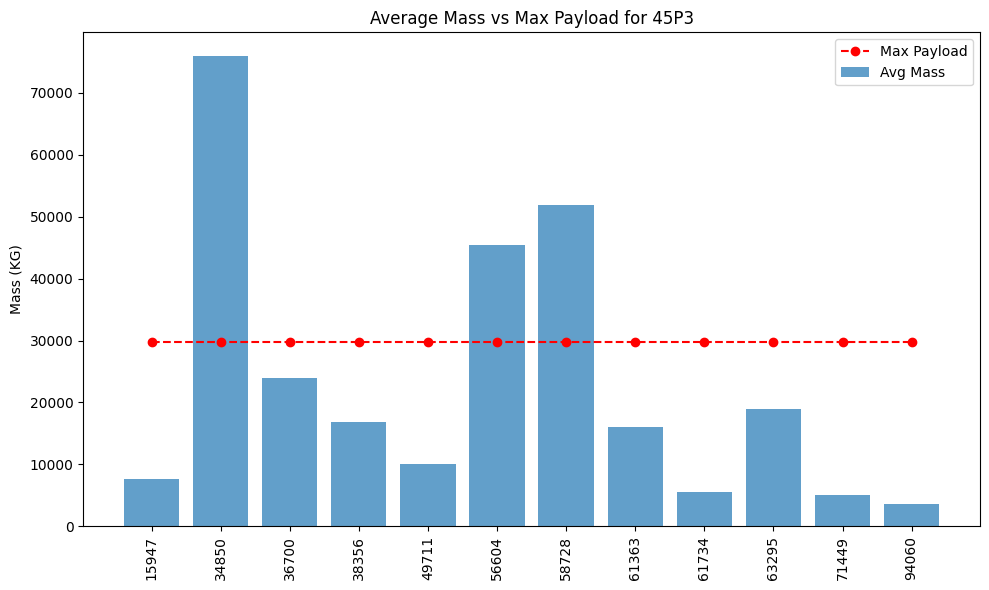

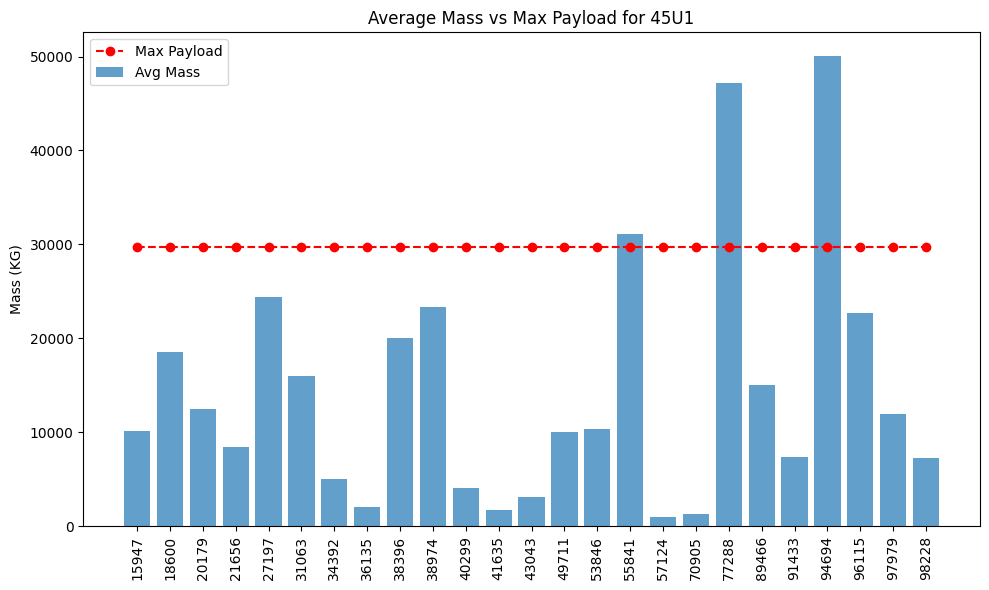

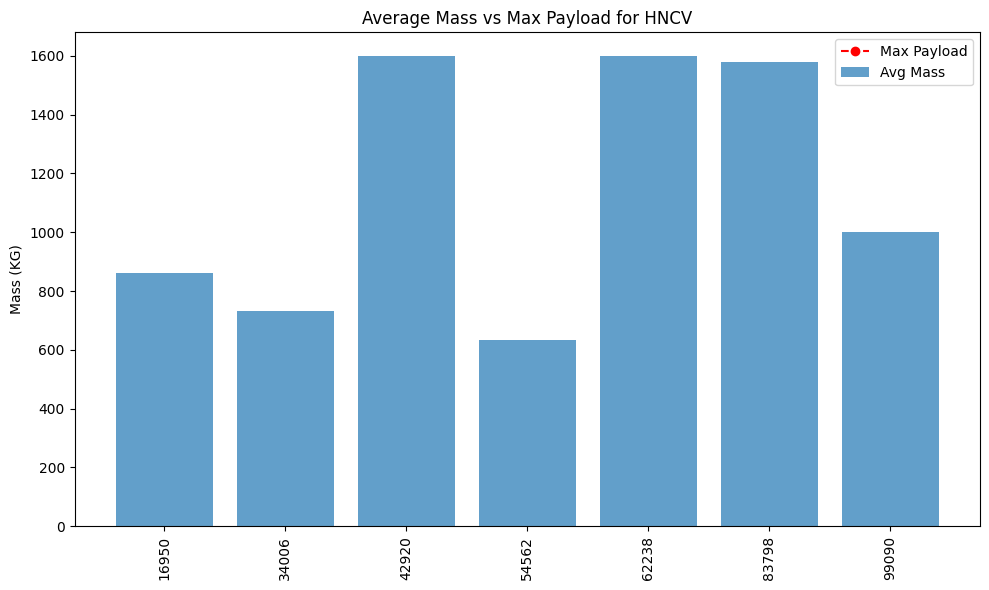

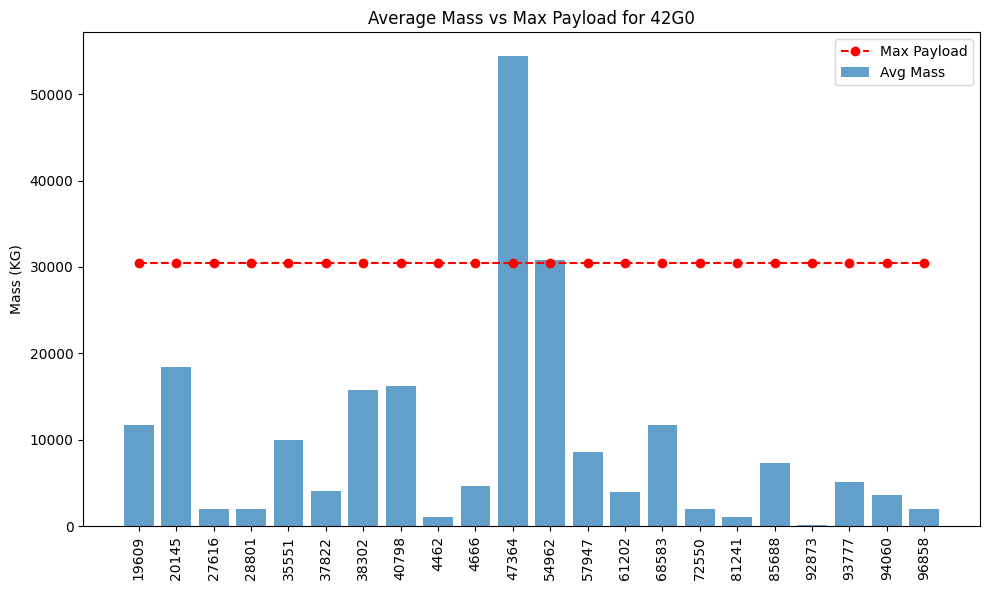

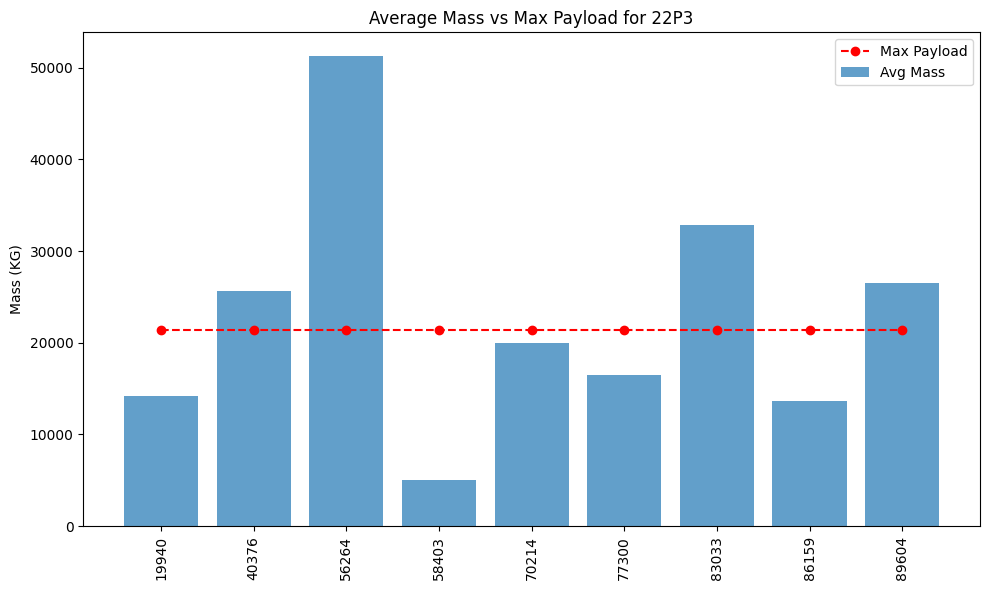

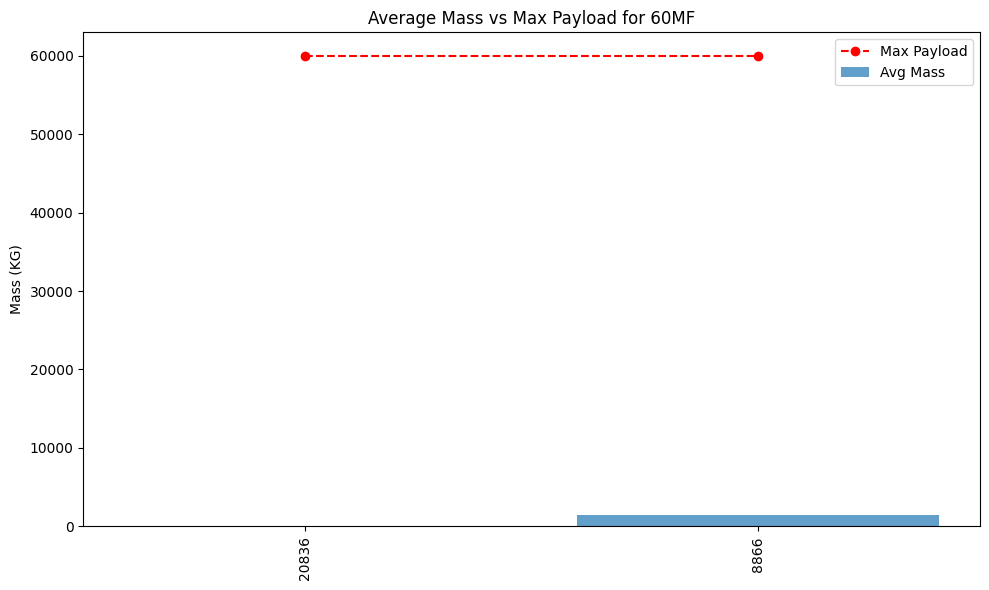

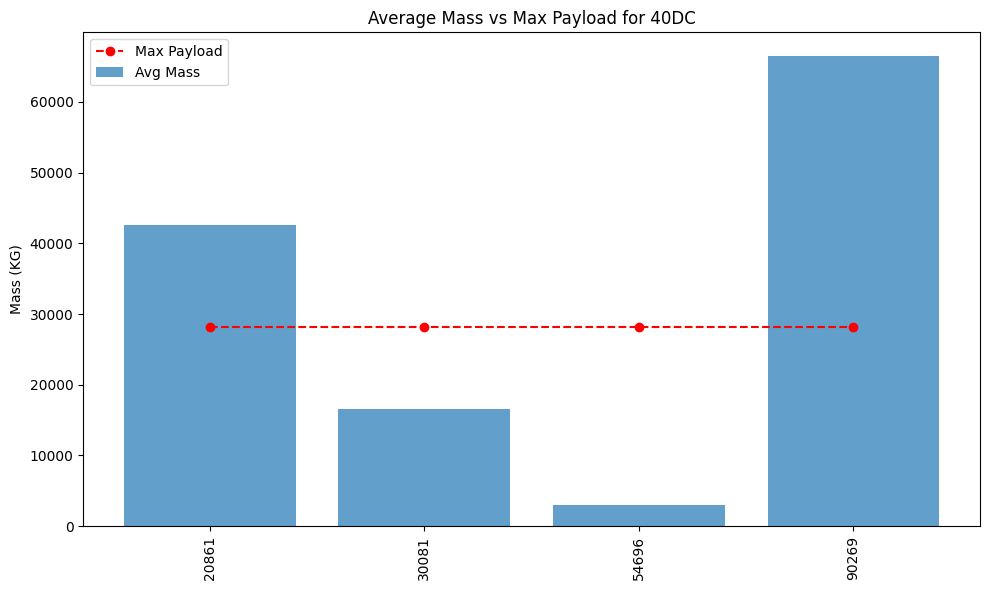

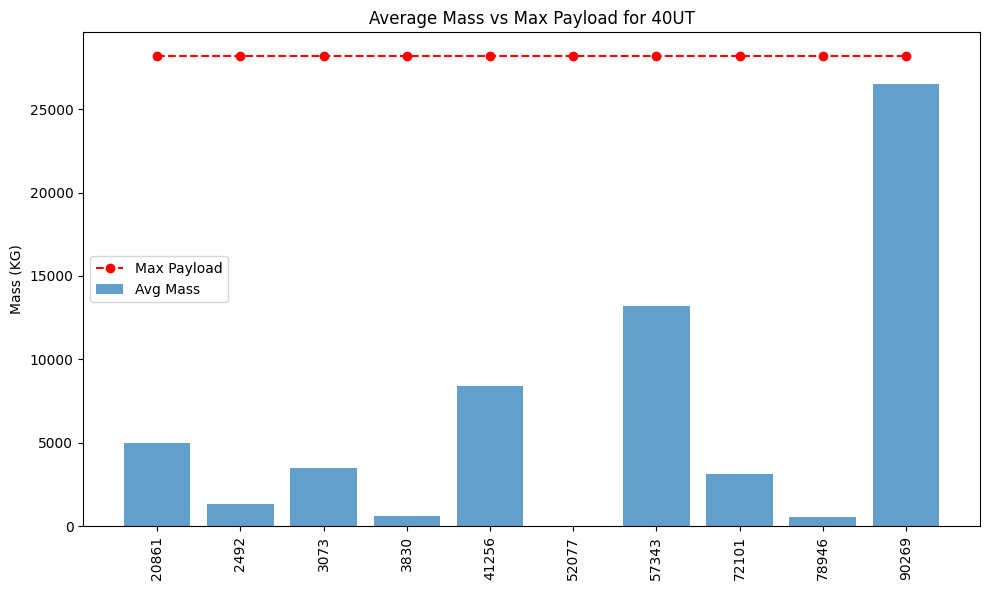

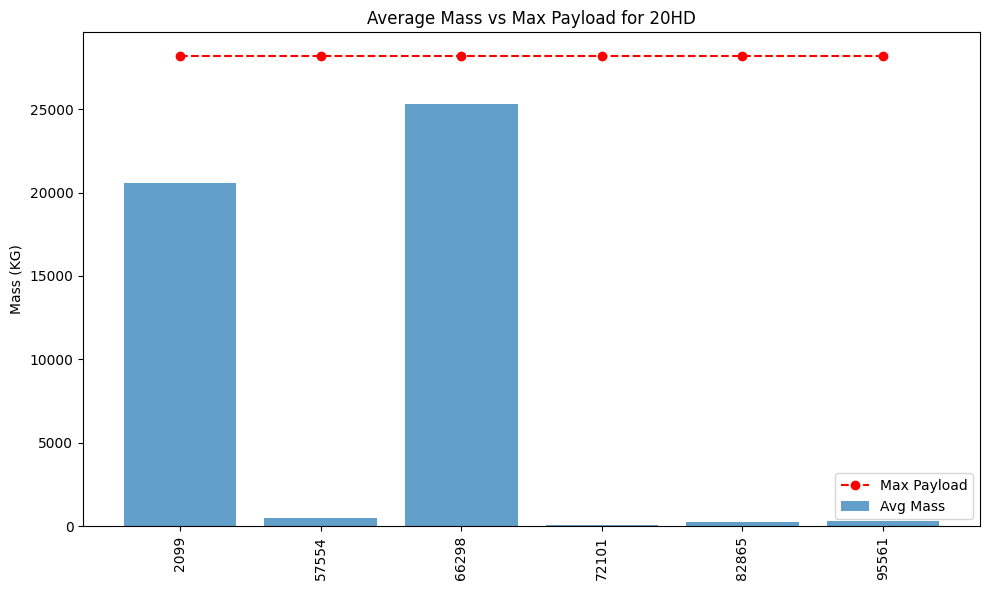

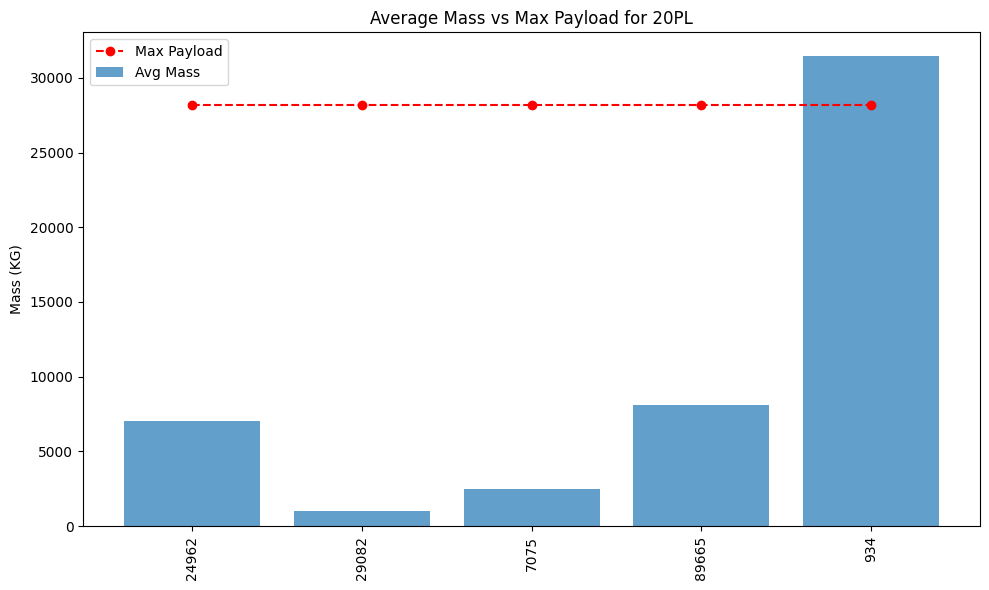

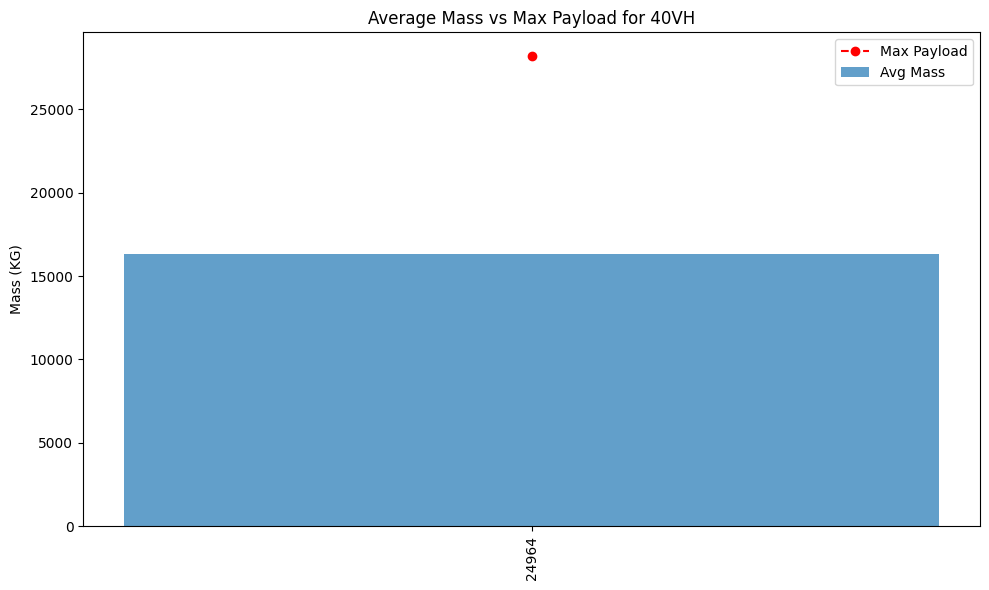

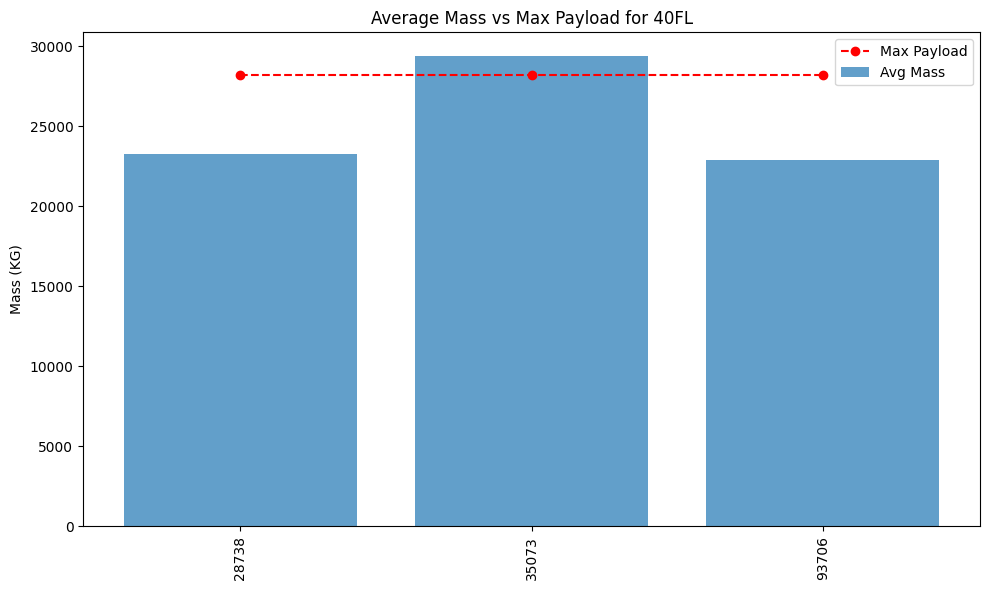

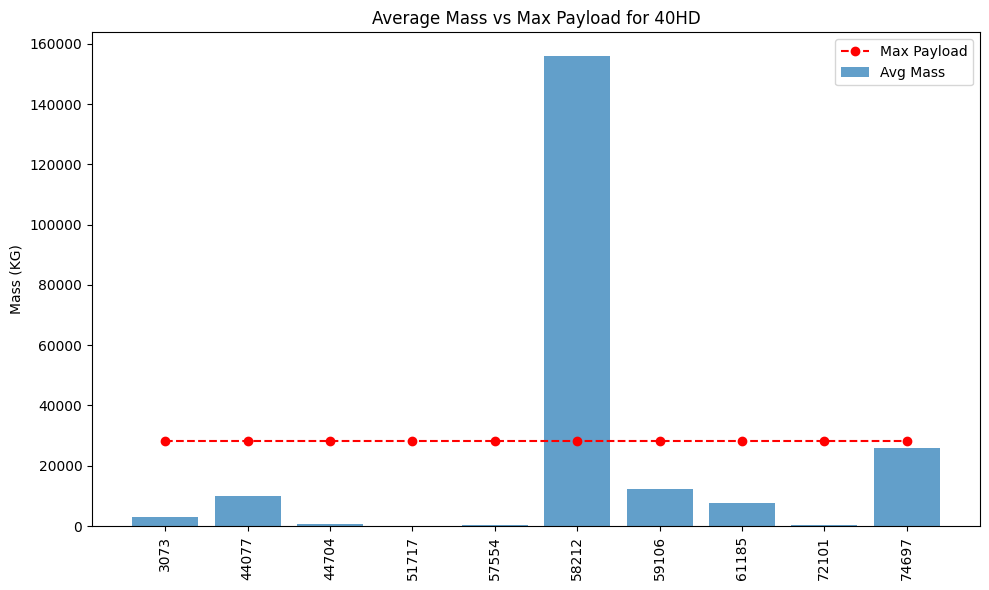

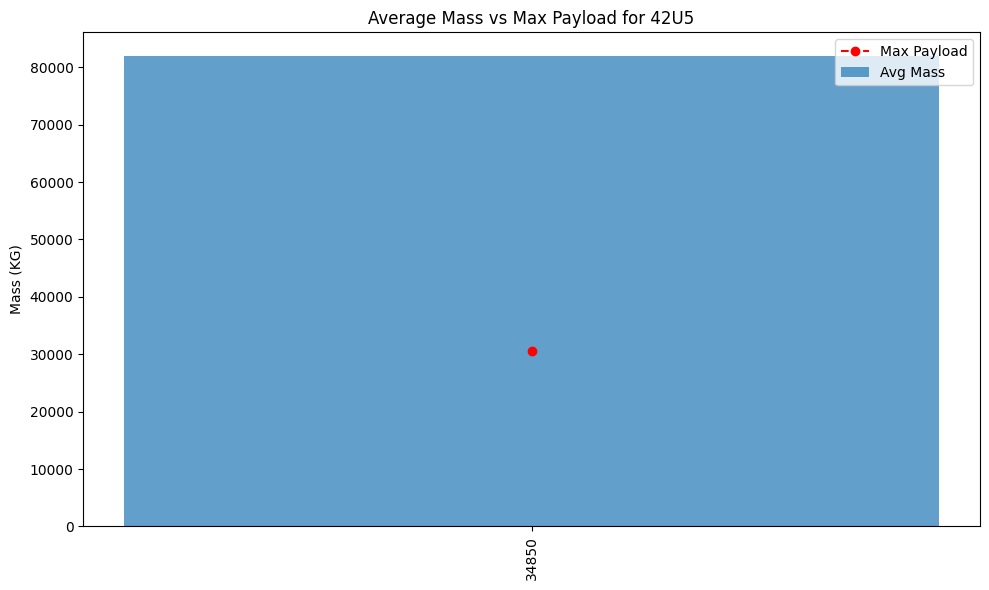

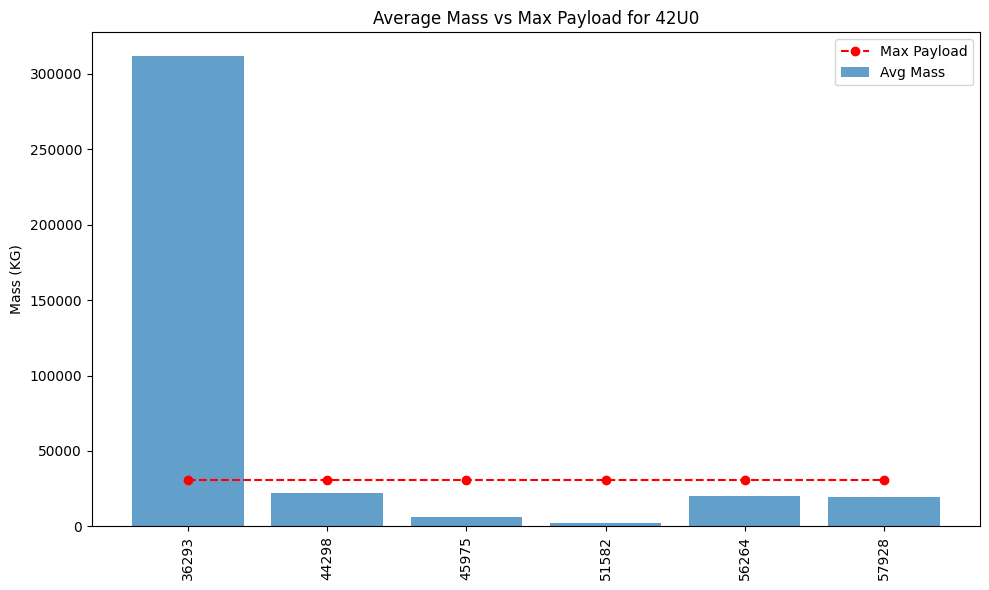

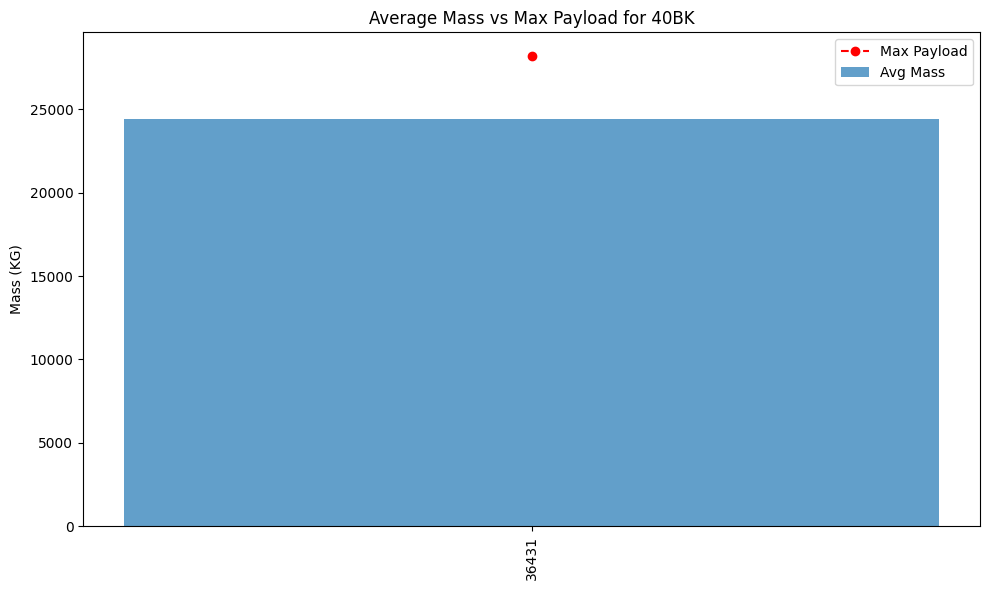

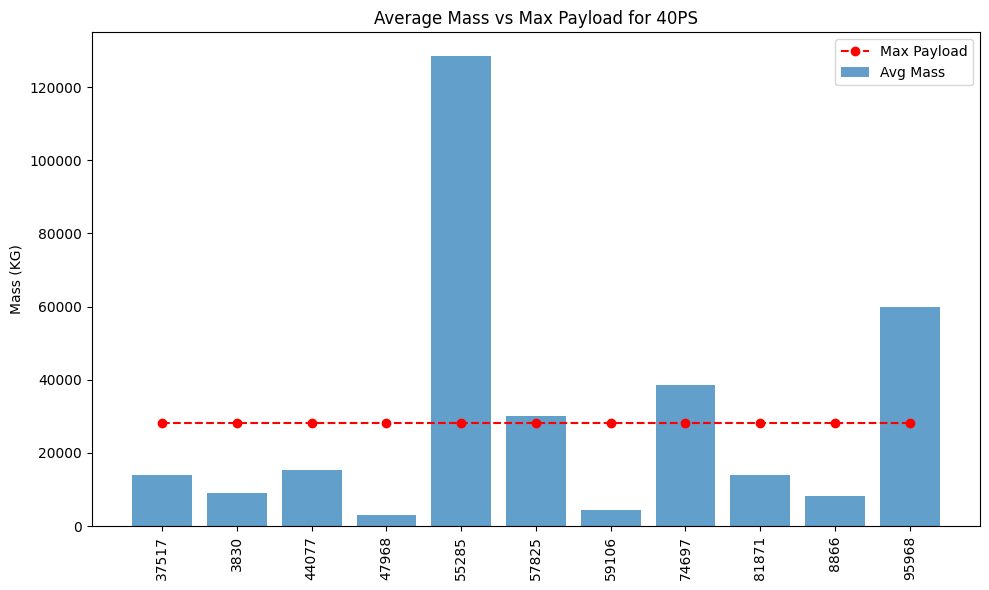

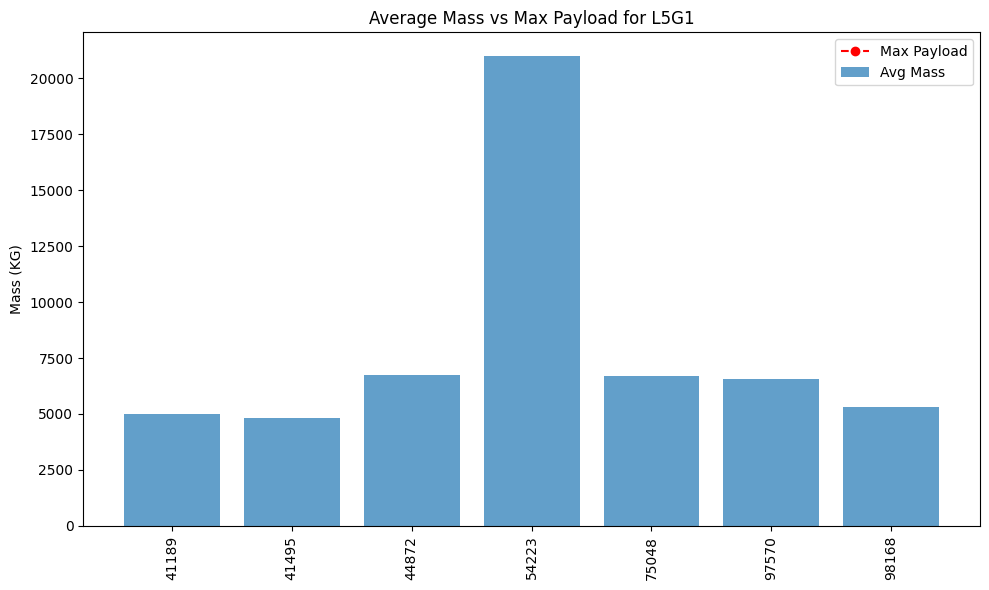

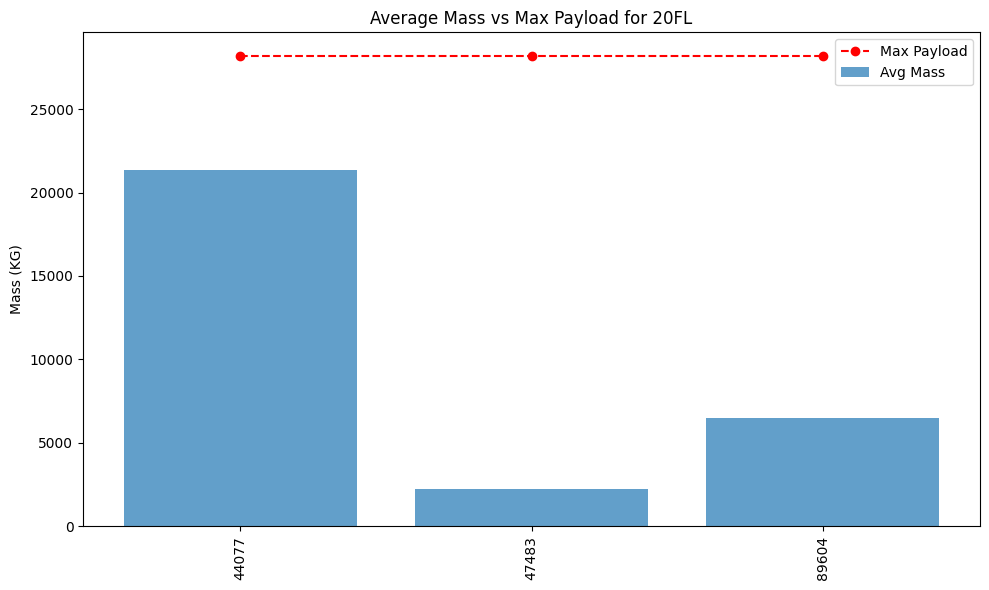

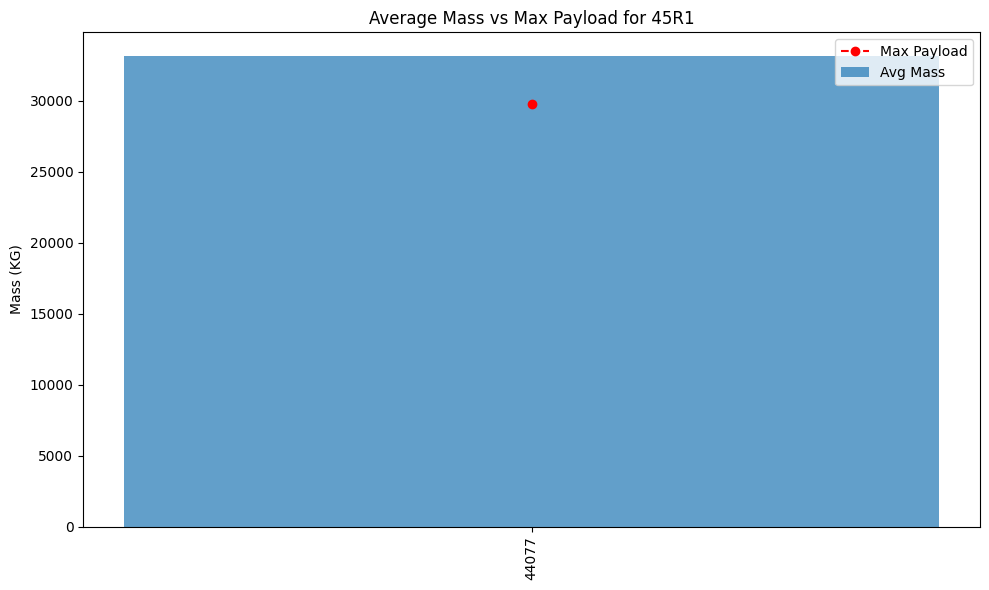

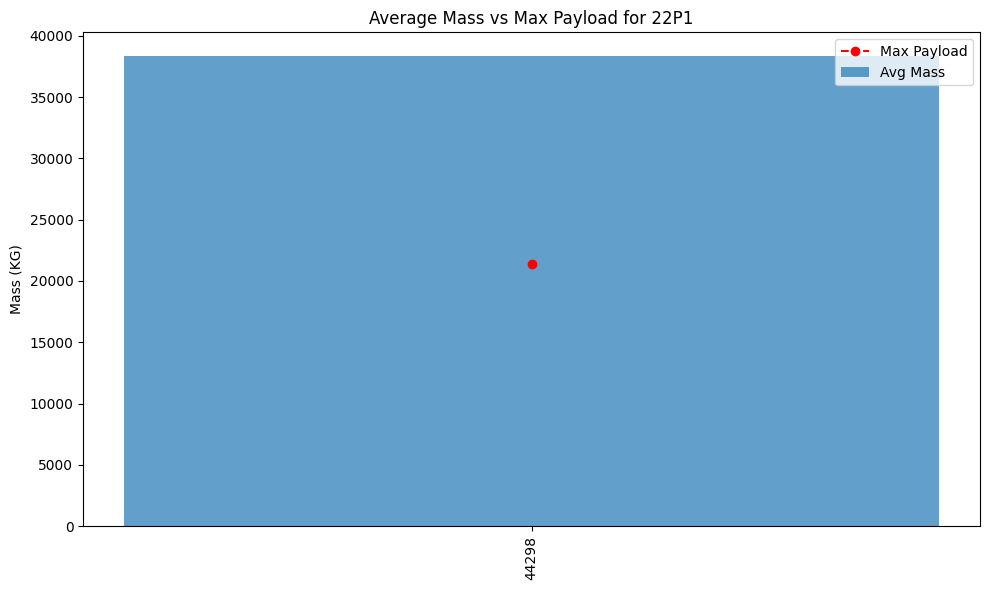

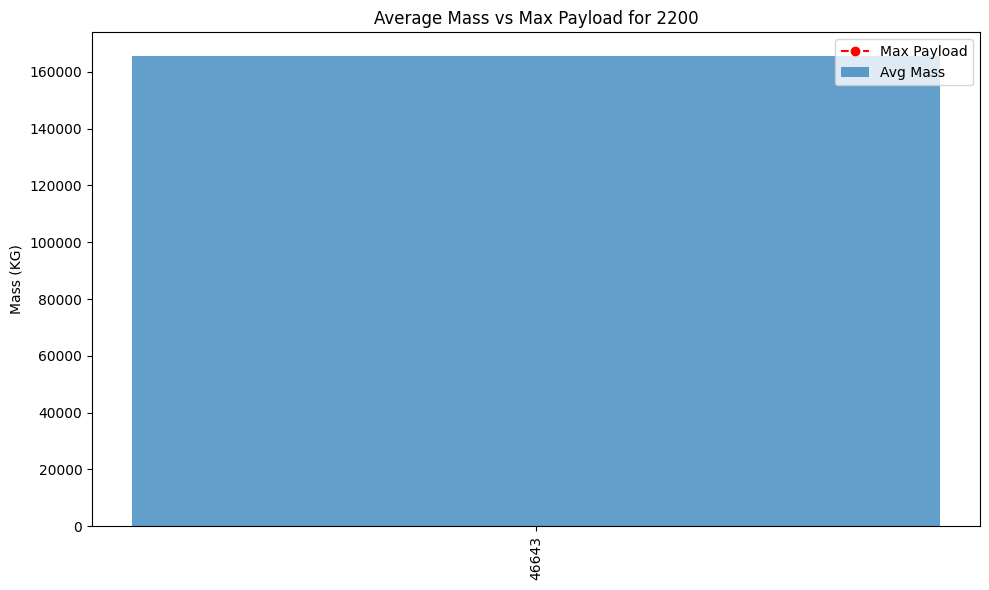

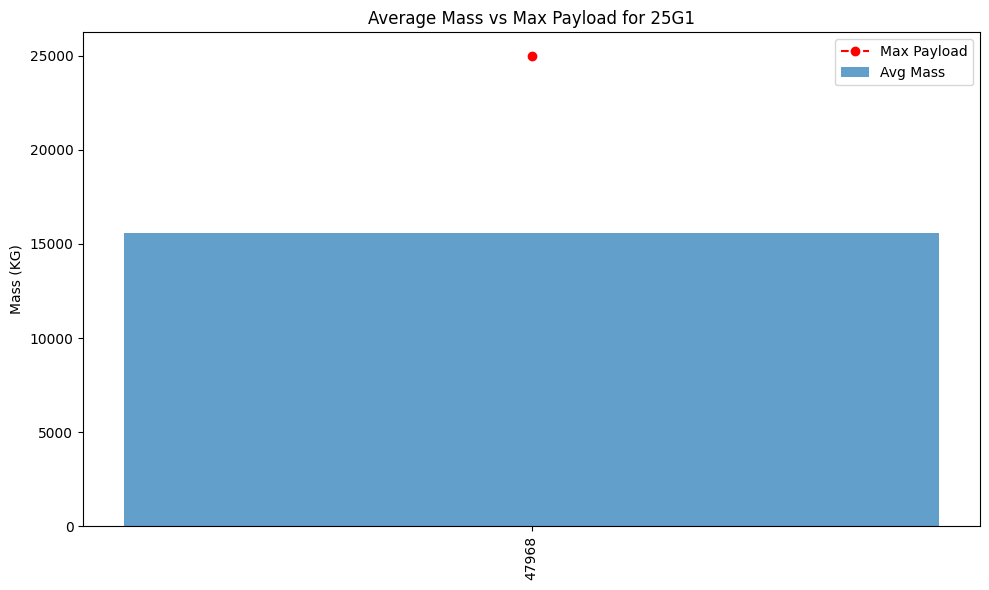

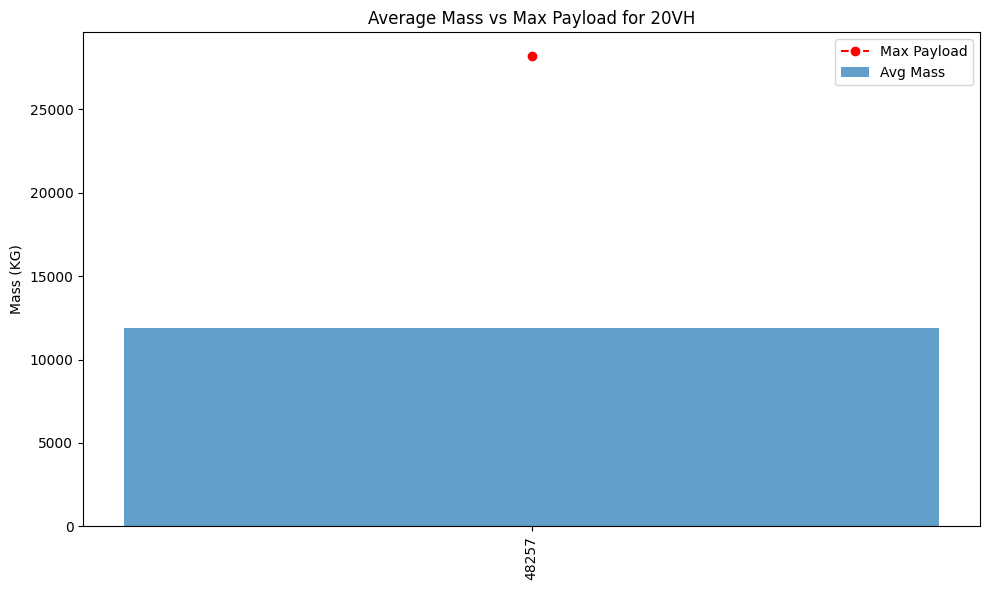

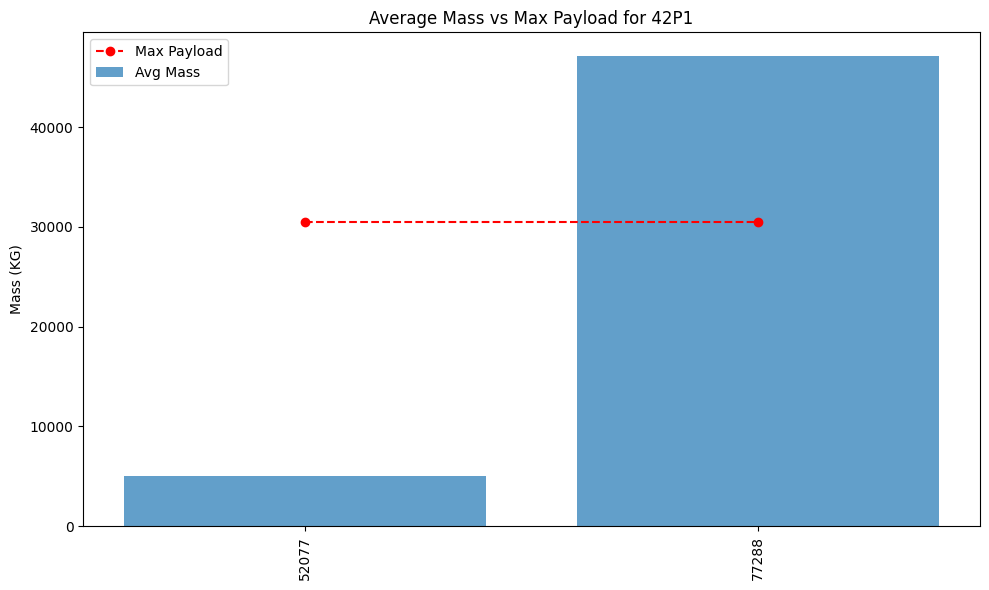

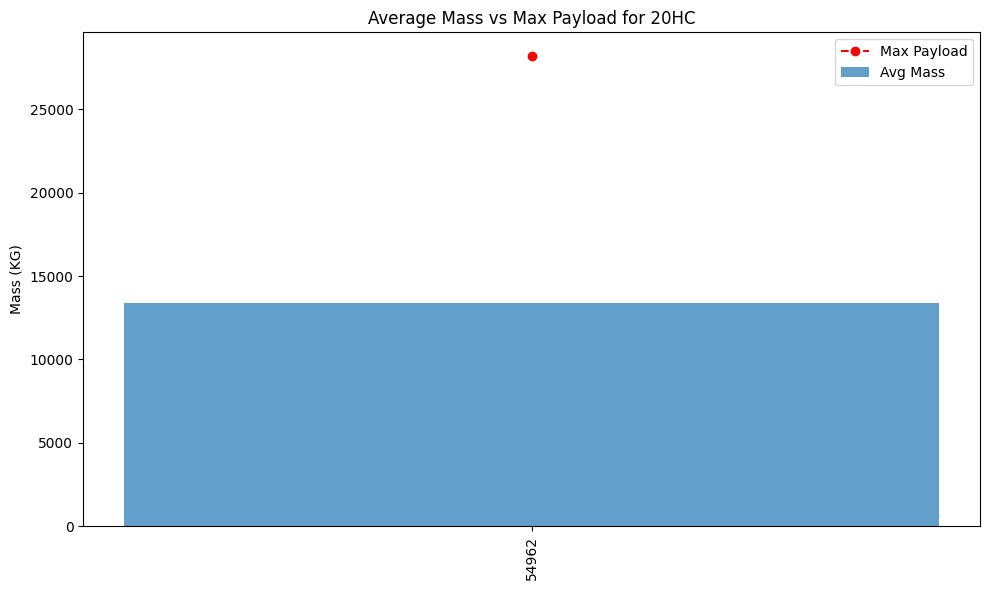

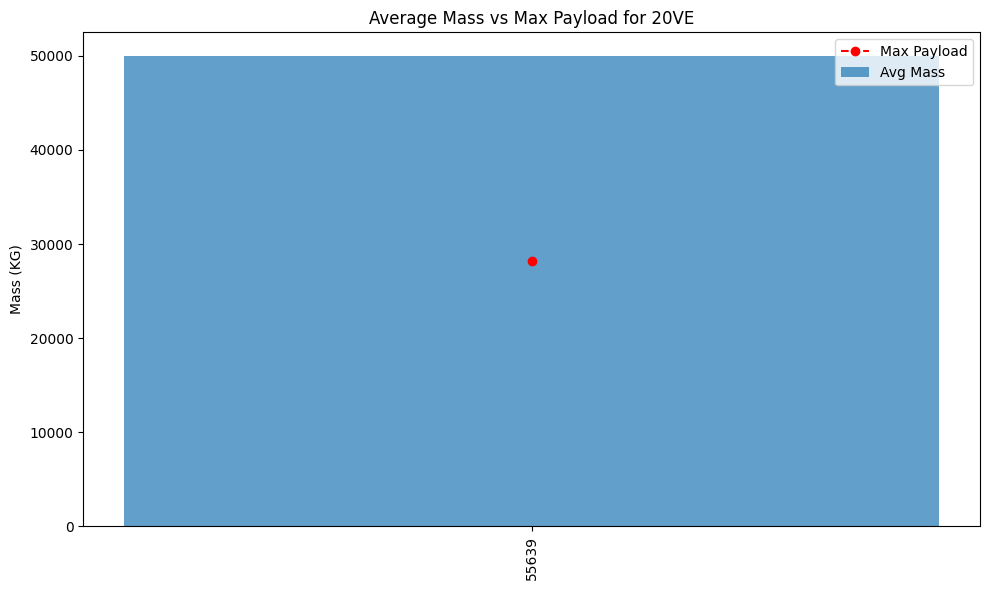

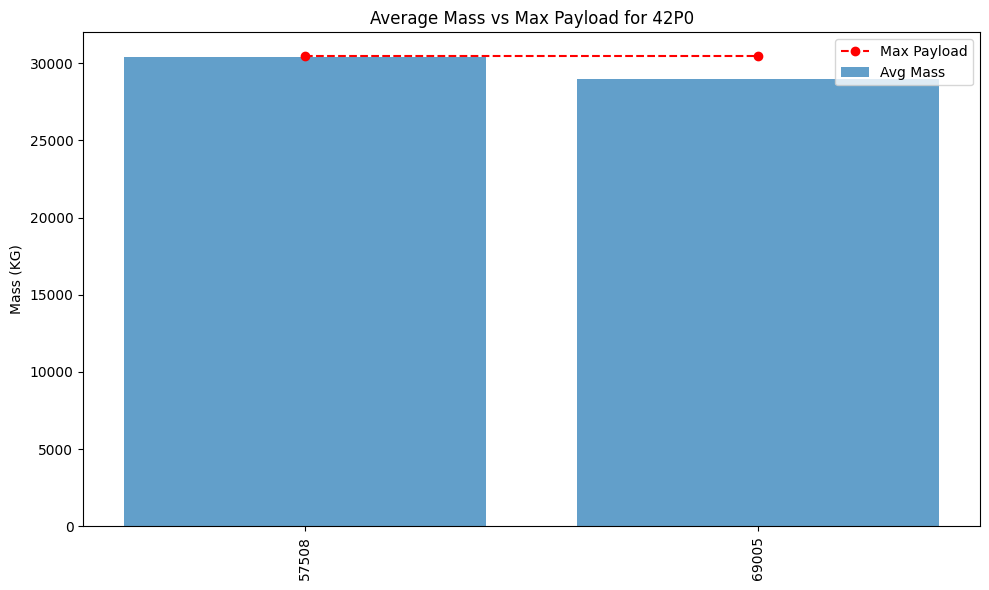

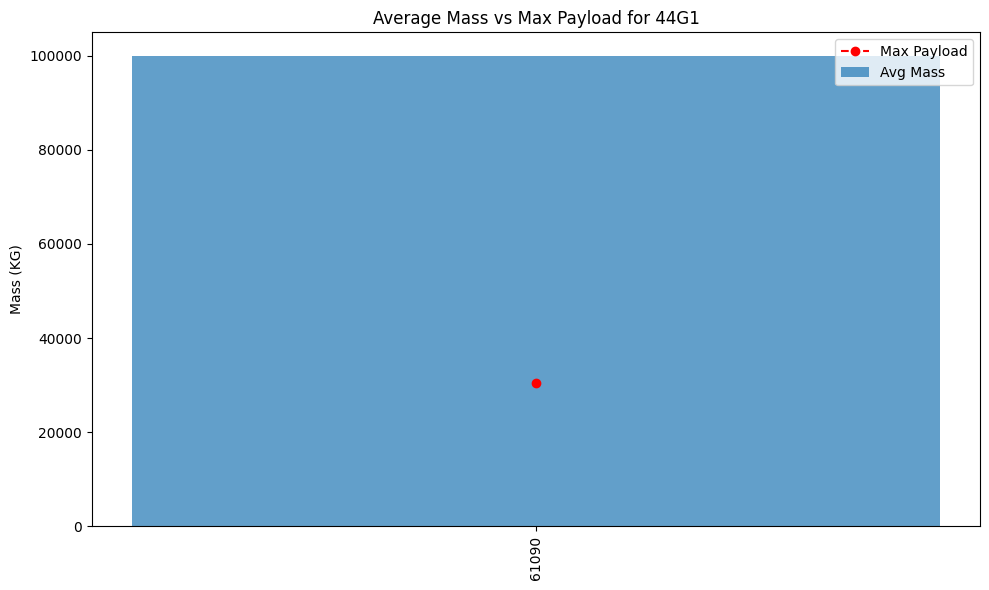

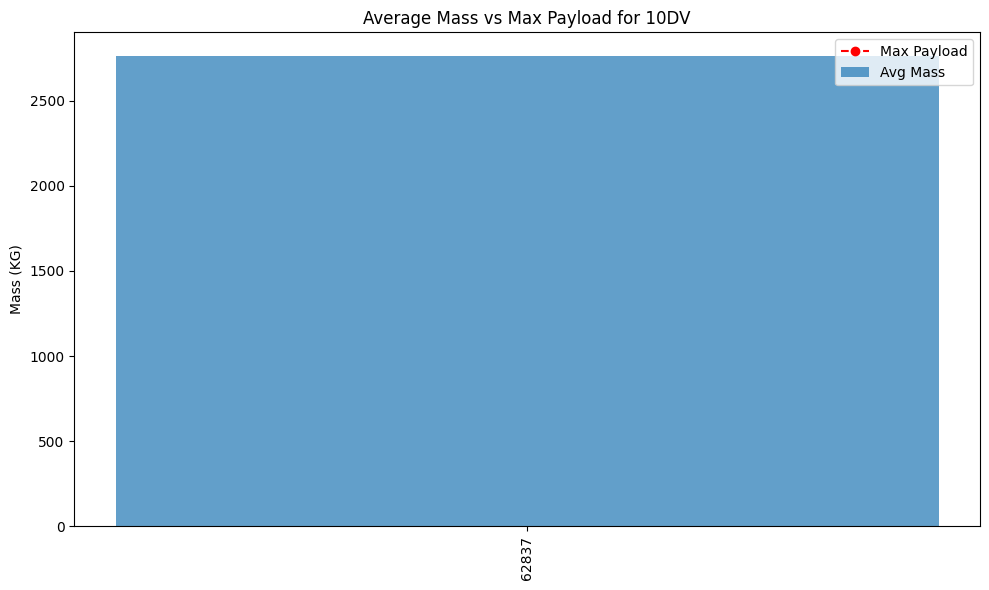

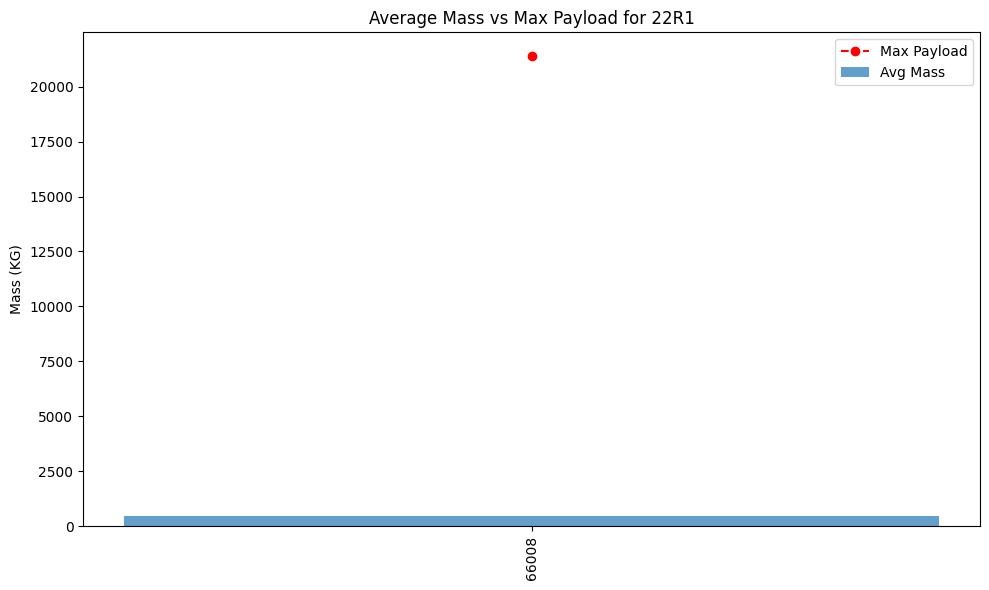

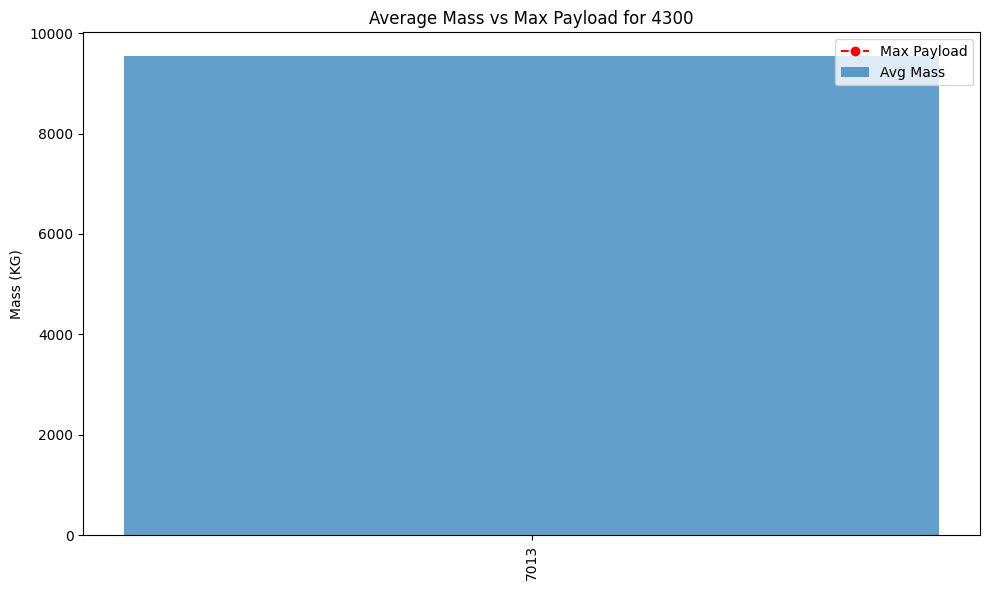

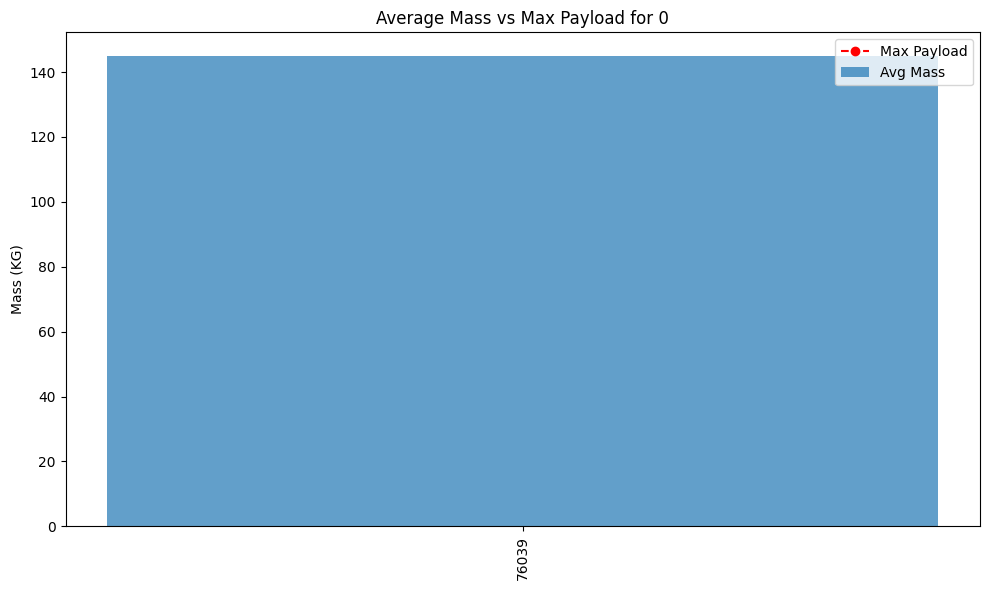

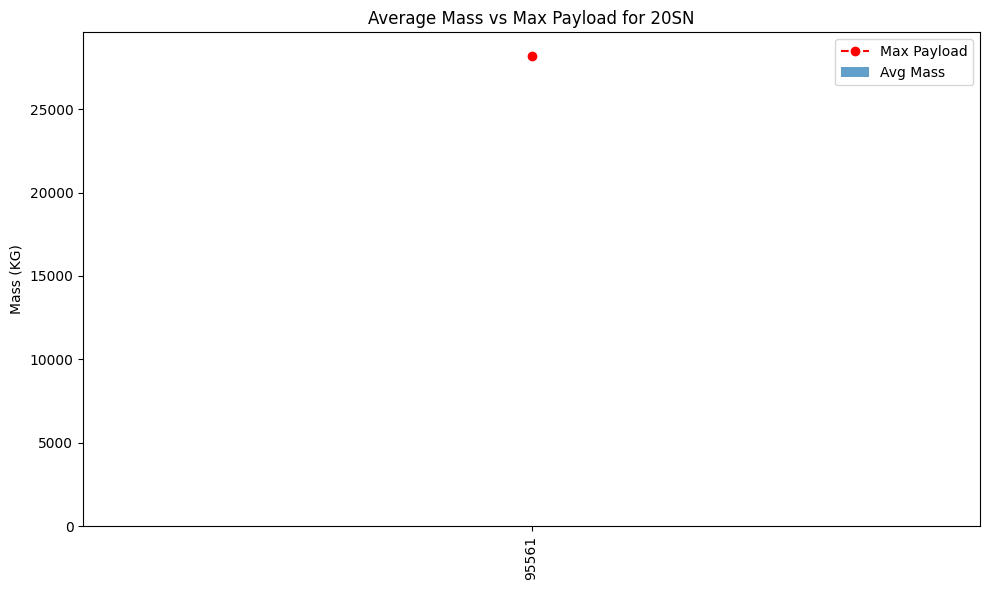

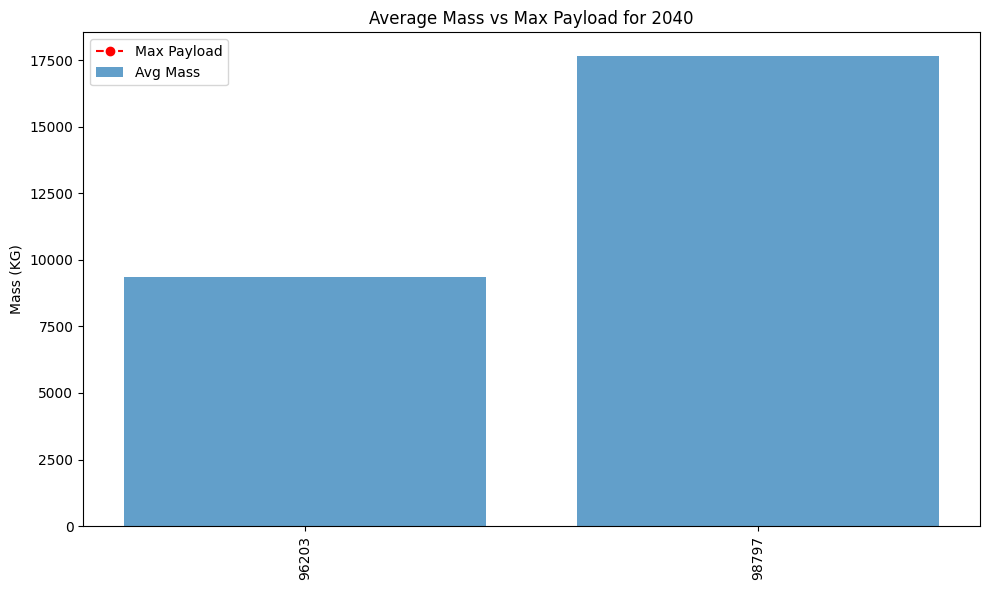

In [35]:


# Plot for each container type separately
for container in avg_mass['Container Size'].unique():
    subset = avg_mass[avg_mass['Container Size'] == container].head(40)

    plt.figure(figsize=(10,6))
    plt.bar(subset['Importer'], subset['Mass(KG)'], label='Avg Mass', alpha=0.7)
    plt.plot(subset['Importer'], subset['Max_Payload'], color='red', marker='o', linestyle='--', label='Max Payload')

    plt.xticks(rotation=90)
    plt.title(f"Average Mass vs Max Payload for {container}")
    plt.ylabel("Mass (KG)")
    plt.legend()
    plt.tight_layout()
    plt.show()
